# Community Water System Prediction Model

The [Division of Drinking Water](https://www.waterboards.ca.gov/drinking_water/programs/) (DDW) at the [California State Water Resources Control Board](https://www.waterboards.ca.gov/) regulates Community Water Systems (CWS) throughout the state. Some of these CWS risk running out of water during the dry summer season.

Here we develop a machine learning model that predicts which CWS face the highest risk of running out of water. The model is intended to run in production on an annual basis, during April of every year.

See the following resources:
* A [searchable website](https://sdwis.waterboards.ca.gov/PDWW/) of community water systems
* A [searchable map](https://gispublic.waterboards.ca.gov/portal/apps/webappviewer/index.html?id=272351aa7db14435989647a86e6d3ad8) of community water systems

In [1]:
import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
import time
import pydotplus
from datetime import datetime as dt_obj
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import dice_ml

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from IPython.display import display, HTML

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 2867)

/Users/monica.bobra/anaconda3/envs/water/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.


### Create 2021 Data

The initial data set provided by the DDW include two csv files that contain data from 2020 and 2021: `DroughtWatchPrioritization_v4.csv` and 
`DroughtWatchPrioritization_v9_input_data_with_TNC.csv`.  The files provide a list of CWS, various parameters that describe the CWS, and the outcome of each CWS at the end of 2021 via the label `DroughtExperienced`. If `DroughtExperienced` equals 1, a CWS ran out of water; otherwise, the system was safe.

In [2]:
BUCKET_NAME = 'aae-water-dev-us-west-2'

In [3]:
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
water_bucket = s3.Bucket(BUCKET_NAME)

In [4]:
def get_data_from_s3(filename):
    for water_bucket_object in water_bucket.objects.all():
        response = s3_client.get_object(Bucket=BUCKET_NAME, Key=filename)
        status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
        print('Status equals {}, getting {}.'.format(status, filename))
        if status == 200:
            df = pd.read_csv(response.get("Body"))
            return(df)

Read in the initial data sets:

In [5]:
df1 = get_data_from_s3(filename='DroughtWatchPrioritization_v4.csv')
df2 = get_data_from_s3(filename='DroughtWatchPrioritization_v9_input_data_with_TNC.csv')

Status equals 200, getting DroughtWatchPrioritization_v4.csv.
Status equals 200, getting DroughtWatchPrioritization_v9_input_data_with_TNC.csv.


The keyword `PWPhysicalAddressLat` in one dataframe is the same as `Lat` in other other; same with longitude. Rename these keywords.

In [6]:
df2 = df2.rename(columns={"Lat": "PWPhysicalAddressLat", "Long": "PWPhysicalAddressLong"})

Merge the two dataframes using these keys: `ServiceConnections`, `Population`, `CDAG_rank`, and `Lat`. The ideal solution is to merge on the unique identifier, `CWSID`. However, `CWSID` is not present in both files.

In [7]:
df_2021_initial = df1.merge(df2, on=['ServiceConnections', 'Population', 'CDAG_rank', 'PWPhysicalAddressLat'])

Remove the '-' character from the HUC8 values to make them consistent with other datasets.

In [8]:
df_2021_initial['HUC8'] = df_2021_initial['HUC8'].str.replace("-", "").astype(int)

Add a column called `Water Year` and set the the values to 2021:

In [9]:
df_2021_initial['Water Year'] = 2021

Rename `EAR2020DroughtRiskScore` to `EARDroughtRiskScore`:

In [10]:
df_2021_initial = df_2021_initial.rename(columns={'EAR2020DroughtRiskScore_y':'EARDroughtRiskScore'}).reset_index(drop=True)

In [11]:
print("In 2021, ",df_2021_initial[df_2021_initial['DroughtExperienced_y'] == 1]['Population'].sum(),"people in California experienced some form of drought.")

In 2021,  1161365 people in California experienced some form of drought.


#### A. Add [US Drought Monitor Data](https://droughtmonitor.unl.edu/)

The US Drought Monitor Database creates a weighted blend of multiple observational data (precipitation, streamflow, reservoir levels, temperature and evaporative demand, soil moisture, vegetation health) into an index called the Drought Severity and Coverage Index (DSCI). These data are available on a weekly cadence from 2000 until the present day.

**Step 1: Obtain a complete list of HUC8 codes in California.** The California Department of Water Resources put a [simplifed mapping HUC8 codes](https://data.ca.gov/dataset/huc8-ca-simplified) within the state of California on the California Open Data Portal. Since HUC8 codes follow watershed boundaries, some span multiple states. This simplified mapping is clipped to the political boundary using ArcGIS.

**Step 2: Obtain DSCI data per HUC8 code per unit time.** 
* The [US Drought Monitor Index](https://droughtmonitor.unl.edu/) provides several drought-related datasets. These data are available through a REST API. 
* Construct the URL for the REST API. The query terms are: 
  * `[area]` = `HUCStatistics`
  * `[statistics type]` = `GetDroughtSeverityStatisticsByAreaPercent` (Note: One could use `GetDSCI`, but this will not return HUC8 codes as a key)
  * `[aoi]` = Any given HUC8 code, e.g. 15040004
  * `[start date]` = 01/01/2021
  * `[end date]` = 01/01/2022
  * `[statistics type]` = 2. (Note: This is a different keyword from the first statistics type. A statistics type of 2 refers to categorical statistics).
* Here is an example URL: url_dsci = `https://usdmdataservices.unl.edu/api/HUCStatistics/GetDroughtSeverityStatisticsByAreaPercent?aoi=15040004&startdate=1/2/2021&enddate=12/27/2021&statisticsType=2`

**Step 3: Calculate the Drought Severity and Coverage Index (DSCI).** Compute a weighted sum of the categorical percent area as described [here](https://droughtmonitor.unl.edu/About/AbouttheData/DSCI.aspx): DSCI = 1(D0) + 2(D1) + 3(D2) + 4(D3) + 5(D4)

Note: As of Monday, July 17 2023, the USDM Rest API is down. I have downloaded all the relevant data from the [comprehensive statistics](https://droughtmonitor.unl.edu/DmData/DataDownload/ComprehensiveStatistics.aspx) page for use temporarily. 

* Select all HUC8 codes that start with 15, 16, 17, and 18.
* Select Statistics Type = Categorical.

Step 1:

In [12]:
url_huc8 = 'https://gis.data.cnra.ca.gov/datasets/02ff4971b8084ca593309036fb72289c_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'

In [13]:
df_huc8 = pd.read_csv(url_huc8)

In [14]:
# Define the dry seasons
dry_seasons_start = [dt_obj.fromisoformat('2022-05-01'), dt_obj.fromisoformat('2021-05-01')]
dry_seasons_end = [dt_obj.fromisoformat('2022-09-30'), dt_obj.fromisoformat('2021-09-30')]

# Define the wet seasons
wet_seasons_start = [dt_obj.fromisoformat('2022-10-01'), dt_obj.fromisoformat('2021-10-01')]
wet_seasons_end = [dt_obj.fromisoformat('2023-04-01'), dt_obj.fromisoformat('2022-04-01')]

Complete Steps 2 and 3:

In [15]:
df_dsci = get_data_from_s3(filename='DSCI.csv')

Status equals 200, getting DSCI.csv.


In [16]:
df_test = pd.read_csv('test.csv')

In [17]:
if len(df_dsci[df_dsci['HUCId'] == 15030102].reset_index()) == 0:
    print("empty")

In [18]:
all_huc_ids = []
all_average_dscis_dry_season = []
all_average_dscis_wet_season = []
all_delta_dscis = []
years_average_dscis_dry_season = []
years_average_dscis_wet_season = []
years_delta_dscis = []
for i in range(len(df_huc8['HUC8'])):
    # Get an individual HUC8 region in California
    one_huc8_code = df_huc8['HUC8'][i]
    df_one_huc = df_dsci[df_dsci['HUCId'] == one_huc8_code].reset_index()
    if len(df_one_huc) == 0:
        print('Empty data for HUC8 region',one_huc8_code, df_huc8['Name'][i])
    else:
        print('Reading data for HUC8 region',one_huc8_code, df_huc8['Name'][i])
        # Convert the keyword MapDate into a datetime object
        df_one_huc['MapDate'] = pd.to_datetime(df_one_huc['MapDate'], format = '%Y%m%d').reset_index(drop=True)

        # Save the data to a list
        all_huc_ids.append(one_huc8_code)

        for j in range(len(dry_seasons_start)):
            # Identify one dry season
            mask_dry = (df_one_huc['MapDate'] > dry_seasons_start[j]) & (df_one_huc['MapDate'] <= dry_seasons_end[j])
            df_dry = df_one_huc[mask_dry]

            # Calculate the maximum, average, and standard deviation of the DSCI during the dry season
            average_dsci_dry_season = np.nanmean(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)
            standard_deviation_dry_season_dsci = np.nanstd(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)

            # Identify one wet season
            mask_wet = (df_one_huc['MapDate'] > wet_seasons_start[j]) & (df_one_huc['MapDate'] <= wet_seasons_end[j])
            df_wet = df_one_huc[mask_wet]

            # Calculate the average DSCI during the wet season
            average_dsci_wet_season = np.nanmean(1*df_wet.D0 + 2*df_wet.D1 + 3*df_wet.D2 + 4*df_wet.D3 + 5*df_wet.D4)

            # Calculate the change in average DSCI between dry and wet seasons
            delta_dsci = average_dsci_dry_season - average_dsci_wet_season

            # Concatenate each feature by years
            years_average_dscis_dry_season.append(average_dsci_dry_season)
            years_average_dscis_wet_season.append(average_dsci_wet_season)
            years_delta_dscis.append(delta_dsci)

        # Save the data to a list
        all_average_dscis_dry_season.append(years_average_dscis_dry_season)
        all_average_dscis_wet_season.append(years_average_dscis_wet_season)
        all_delta_dscis.append(years_delta_dscis)

        years_average_dscis_dry_season = []
        years_average_dscis_wet_season = []
        years_delta_dscis = []

Reading data for HUC8 region 18100204 Salton Sea
Reading data for HUC8 region 18070303 San Luis Rey-Escondido
Reading data for HUC8 region 18070304 San Diego
Reading data for HUC8 region 18020162 Upper Putah
Reading data for HUC8 region 18050001 Suisun Bay
Reading data for HUC8 region 15030102 Piute Wash
Reading data for HUC8 region 18100100 Southern Mojave
Reading data for HUC8 region 18030003 Middle Kern-Upper Tehachapi-Grapevine
Reading data for HUC8 region 18060003 Carrizo Plain
Reading data for HUC8 region 18060007 Cuyama
Reading data for HUC8 region 18070102 Santa Clara
Reading data for HUC8 region 18090206 Antelope-Fremont Valleys
Reading data for HUC8 region 18020002 Upper Pit
Reading data for HUC8 region 18080002 Madeline Plains
Reading data for HUC8 region 17100309 Applegate
Reading data for HUC8 region 17100311 Illinois
Reading data for HUC8 region 18030009 Upper Dry
Reading data for HUC8 region 18040001 Middle San Joaquin-Lower Chowchilla
Reading data for HUC8 region 181002

In [19]:
df_drought_data_2021 = pd.DataFrame({
                   'HUC8': all_huc_ids,
                   'Water Year': [2021]*len(all_huc_ids),
                   'DSCI Dry Season Average': [item[0] for item in all_average_dscis_dry_season],        
                   'DSCI Wet Season Average': [item[0] for item in all_average_dscis_wet_season],
                   'DSCI Dry Wet Delta': [item[0] for item in all_delta_dscis],
})

In [20]:
df_drought_data_2022 = pd.DataFrame({
                   'HUC8': all_huc_ids,
                   'Water Year': [2022]*len(all_huc_ids),
                   'DSCI Dry Season Average': [item[1] for item in all_average_dscis_dry_season],        
                   'DSCI Wet Season Average': [item[1] for item in all_average_dscis_wet_season],
                   'DSCI Dry Wet Delta': [item[1] for item in all_delta_dscis],
})

In [21]:
df_drought_data_2021[df_drought_data_2021['HUC8'] == 18100204]

,HUC8,Water Year,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta
0,18100204,2021,320.326818,174.214615,146.112203


In [22]:
df_2021 = df_2021_initial.merge(df_drought_data_2021, on=['HUC8'], how='left')

In [23]:
df_2021['DSCI Dry Season Average'] = df_2021['DSCI Dry Season Average'].fillna(0)
df_2021['DSCI Wet Season Average'] = df_2021['DSCI Wet Season Average'].fillna(0)
df_2021['DSCI Dry Wet Delta'] = df_2021['DSCI Dry Wet Delta'].fillna(0)

#### B. Add SAFER 2021 Data

Table A2 of the [SAFER 2023 Drinking Water Needs Assessment](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023needsassessment.pdf) indicates each component of the SAFER score. These data are available in [attachment A1](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/docs/a1.xlsx) of the 2021 [SAFER Archives](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html). Here we will query one remaining component called "Number of Sources", which is available under the column titled "Total" under the tab titled "Accessibility Raw Data".

In [24]:
df_SAFER_2021 = get_data_from_s3(filename='SAFER_2021.csv')

Status equals 200, getting SAFER_2021.csv.


In [25]:
df_SAFER_2021 = df_SAFER_2021[['PWSID','Total']].rename(columns={'PWSID': 'CWSID', 'Total':'Total Number of Water Sources'})

In [26]:
df_2021 = df_2021.merge(df_SAFER_2021, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Some CWS do not have a value for total number of water sources. Assume they only have one source.

In [27]:
df_2021['Total Number of Water Sources'] = df_2021['Total Number of Water Sources'].fillna(1)

#### C. Refine Keywords for 2021 Data

Rename columns so they make more sense.

In [28]:
df_2021.columns = df_2021.columns.str.removesuffix("_x")
df_2021.columns = df_2021.columns.str.removesuffix("_y")

In [29]:
# Drop duplicate columns
df_2021 = df_2021.loc[:,~df_2021.columns.duplicated()].copy()

Redefine the following keys: 
* `CentralValleyCounties`: No is set to zero and everything else is set to 1.
* `FracturedRock`: Set string '0-000' to 0 and set 'FR-999' to 1.
* `CurtailedWatershed`: Set string 'NotInCurtailedWatershed' to 0 and everything else to 1.

Create the following new keys:
* `HUC_Categories`: The keys `HUC8_CentralValley`, `HUC8_Coast`, and `HUC8_Other` contain values that include 8-digit HUC codes or strings. The string values are identical to the keyword names (i.e. 'HUC8_CentralValley', 'HUC8_Coast', and 'HUC8_Other'). Set these string values to 1, 2, and 3, respectively, and gather these into a separate keywords called 'HUC8_Categories'.

Skip the following keys:
* `Basin_Number_part1`, `Basin12`, `Basin34`, `Basin5`, `Basin6`, `Basin789`: Ignore these variables for now to avoid introducing noise into the data set (by one-hot-encoding six variables, all of which have many possible values).

In [30]:
# Redefine CentralValleyCounties
region_dictionary = {'No':0, 'BUTTE':1, 'COLUSA':1, 'FRESNO':1, 'GLENN':1, 'KERN':1, 'KINGS':1,
       'MADERA':1, 'MERCED':1, 'PLACER':1, 'SACRAMENTO':1, 'SAN JOAQUIN':1,
       'SHASTA':1, 'SOLANO':1, 'STANISLAUS':1, 'SUTTER':1, 'TEHAMA':1, 'TULARE':1,
       'YOLO':1, 'YUBA':1}
df_2021['CentralValleyCounties'] = df_2021['CentralValleyCounties'].apply(lambda x: region_dictionary[x])

In [31]:
# Redefine FracturedRock
fracturedrock_dictionary = {'0-000':0, 'FR-999':1}
df_2021['FracturedRock'] = df_2021['FracturedRock'].apply(lambda x: fracturedrock_dictionary[x])

In [32]:
# Redefine CurtailedWatershed
watershed_dictionary = {'NotInCurtailedWatershed':0, 'PartialSacSJ':1, 'PartialSJ':1,
       'SanJoaquinRiver':1, 'SacramentoRiver':1, 'SacSJ':1, 'RussianRiver':1,
       'PartialRus':1, 'PartialSac':1, 'ScottRiver':1, 'ShastaRiver':1,
       'PartialShasta':1}
df_2021['CurtailedWatershed'] = df_2021['CurtailedWatershed'].apply(lambda x: watershed_dictionary[x])

In [33]:
# Create HUC_Categories

df_2021['HUC8_CentralValley'] = df_2021['HUC8_CentralValley'].replace(to_replace='180*', value=0, regex=True)
df_2021['HUC8_Coast'] = df_2021['HUC8_Coast'].replace(to_replace='180*', value=0, regex=True)
df_2021['HUC8_Other'] = df_2021['HUC8_Other'].replace(to_replace='180*', value=0, regex=True)
df_2021['HUC8_Other'] = df_2021['HUC8_Other'].replace(to_replace='160*', value=0, regex=True)

df_2021 = df_2021.replace(to_replace='HUC8_Coast', value=1)
df_2021 = df_2021.replace(to_replace='HUC8_CentralValley', value=2)
df_2021 = df_2021.replace(to_replace='HUC8_Other', value=3)

df_2021['HUC_Categories'] = np.nan

df_2021['HUC_Categories'] = df_2021[['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other']].max(axis=1, numeric_only=True)

df_2021 = df_2021.drop(columns=['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other'])

#### D. Re-calculate outcome label `DroughtExperienced`

For the 2021 data, the label `DroughtExperienced` was based on five variables: `WaterOutageDroughtViolation`, `BottledHauledWaterOrZeroSource`, `CurtailmentExemptionPetition`, `Score_1704`, and `FundedProject`. If any of these variables had a value of 1, then the `DroughtExperienced` had a value of 1. If all of these variables had a value of 0, then `DroughtExperienced` had a value of 0. Later, it was discovered that `Score_1702` should have been factored into `DroughtExperienced`.

Moving forward, there are several options for dealing with the outcome label `DroughtExperienced`:
1. Stick with the method used to derive the 2021 dataset,
2. Calculate a new version of `DroughtExperienced` by incorporating `Score_1702`. In other words, if `Score_1702` or any of the other five variables have a value of 1, then `DroughtExperienced` equals 1. Otherwise, it equals zero. This option requires going re-calculating `DroughtExperienced`. 

Here we choose option 2.

In [34]:
# Rewrite all values of DroughtExperienced with np.NaN
df_2021['DroughtExperienced'] = np.NaN

In [35]:
df_2021['DroughtExperienced'].unique()

array([nan])

In [36]:
conditions = [
    (df_2021['WaterOutageDroughtViolation'].eq(1)) |
    (df_2021['BottledHauledWaterOrZeroSource'].eq(1)) |
    (df_2021['Score_1702'].eq(1)) |
    (df_2021['CurtailmentExemptionPetition'].eq(1)) |
    (df_2021['Score_1704'].eq(1)) |
    (df_2021['FundedProject'].eq(1))    
]

choicelist = [1]

In [37]:
df_2021['DroughtExperienced'] = np.select(conditions, choicelist, default=0)

In [38]:
df_2021['DroughtExperienced'].unique()

array([0, 1])

In [39]:
df_2021.shape

(2866, 55)

#### E. Flag some data quality issues

Why are there multiple CWS at the same location?

In [40]:
df_2021[['CWSID', 'ServiceConnections', 'Population', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']][30:39]

,CWSID,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong
30,CA0310003,1742,4943,38.382864,-120.787745
31,CA0310004,520,1060,38.480957,-120.847427
32,CA0310005,388,907,38.413058,-120.658861
33,CA0310006,215,510,38.544707,-120.741079
34,CA0310008,211,1184,38.191586,-120.829103
35,CA0310011,337,838,38.458547,-120.541518
36,CA0310012,2743,8809,38.382864,-120.787745
37,CA0310018,82,200,38.447565,-120.537917
38,CA0310019,55,188,38.382864,-120.787745


Why are there 38 CWSIDs with a population of zero? It looks like these are wholesalers that only sell water; however, SDWIS assigns a population to these CWS, e.g. [CA3710042](https://sdwis.waterboards.ca.gov/PDWW/JSP/WaterSystemDetail.jsp?tinwsys_is_number=3927&tinwsys_st_code=CA) serves 3.3M people.

In [41]:
df_2021[df_2021['Population'] == 0.0][['CWSID','Population']]

,CWSID,Population
415,CA1410002,0
416,CA1410003,0
417,CA1410004,0
426,CA1410510,0
586,CA1510040,0
594,CA1510053,0
757,CA1910032,0
765,CA1910041,0
769,CA1910045,0
772,CA1910048,0


#### E. Select keywords to use in model

In [42]:
keywords_to_use_in_the_model = [
 'CWSID',                   # Unique Identifier
 'Water Year',              # Unique Identifier
 'HUC8',                    # Unique Identifier
 'DroughtExperienced',      # Labels
 'WaterOutageDroughtViolation',
 'BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition',
 'FundedProject',            
 'DSCI Dry Season Average', # Drought Information
 'DSCI Wet Season Average',
 'DSCI Dry Wet Delta', 
 'Intertie',               # Infrastructure Information
 'ServiceConnections',
 'Population',
 'Score_SCV',              # Risk Scores
 'Score_SCM',
 'Curtailment',
 'Score_CriticallyOverdraftedGroundwaterBasin',
 'PWPhysicalAddressLong',  # Location Information
 'PWPhysicalAddressLat',
 'HUC_Categories',
 'Score_1702', 
 'Total Number of Water Sources'
]

In [43]:
df_2021 = df_2021[keywords_to_use_in_the_model]

In [44]:
df_2021.columns

Index(['CWSID', 'Water Year', 'HUC8', 'DroughtExperienced',
       'WaterOutageDroughtViolation', 'BottledHauledWaterOrZeroSource',
       'CurtailmentExemptionPetition', 'FundedProject',
       'DSCI Dry Season Average', 'DSCI Wet Season Average',
       'DSCI Dry Wet Delta', 'Intertie', 'ServiceConnections', 'Population',
       'Score_SCV', 'Score_SCM', 'Curtailment',
       'Score_CriticallyOverdraftedGroundwaterBasin', 'PWPhysicalAddressLong',
       'PWPhysicalAddressLat', 'HUC_Categories', 'Score_1702',
       'Total Number of Water Sources'],
      dtype='object')

In [45]:
df_2021.shape

(2866, 23)

### Create 2022 Data

The original data covered the year 2021. Add data that covers the year 2022.
Follow the steps in the [Analytical File Specifications](https://docs.google.com/document/d/104HVf3_-9r174I6ZWnu0zzyngckeEz19HmvarQ5yJpM/edit).

#### A. Create a new dataframe for the 2022 data

Create a new dataframe for 2022 data and add the US Drought Monitor data for 2022.

In [46]:
df_2022 = df_2021[['CWSID', 'HUC8']]

In [47]:
df_2022.shape

(2866, 2)

In [48]:
df_2022 = df_2022.merge(df_drought_data_2022, on='HUC8', how='left')

In [49]:
df_2022['Water Year'] = 2022

#### B. Add the labels

There are four labels currently in the model:
1. `WaterOutageDroughtViolation`
2. `BottledHauledWaterOrZeroSource`
3. `FundedProject`
4. `CurtailmentExemptionPetition`
5. `Score_1702`

Potentially add `Score_1704`.

##### 1. `WaterOutageDroughtViolation`
These data are in the file `Water_Outage_Report_SDWISViolations.csv`.

In [50]:
df_outage = get_data_from_s3(filename='Water_Outage_Report_SDWISViolations.csv')

Status equals 200, getting Water_Outage_Report_SDWISViolations.csv.


In [51]:
# Retain only three fields and rename water system id to CWSID
df_outage = df_outage[['water system id', 'Begin Date', 'End Date']].rename(columns={'water system id': 'CWSID'})

In [52]:
df_2022 = df_2022.merge(df_outage, how='left').drop_duplicates().reset_index(drop=True)

In [53]:
df_2022['WaterOutageDroughtViolation'] = np.NaN

In [54]:
# Convert the keywords Begin Date and End Date into a datetime object
df_2022['Begin Date'] = pd.to_datetime(df_2022['Begin Date'], format = '%Y-%m-%d')
df_2022['End Date'] = pd.to_datetime(df_2022['End Date'], format = '%Y-%m-%d')

In [55]:
# Identify the 2022 water season
# Define the dry season 2021
start_2022_water_season = dt_obj.fromisoformat('2021-10-01')
end_2022_water_season = dt_obj.fromisoformat('2022-09-30')

Step 1: Identify all cases where a `Begin Date` and `End Dat`e fall within any point of the 2022 water season (10/2021 - 9/2022). This identifies three cases.

In [56]:
mask_2022_water_season_1 = (df_2022['Begin Date'] > start_2022_water_season) & (df_2022['End Date'] <= end_2022_water_season)
df_water_season_1 = df_2022[mask_2022_water_season_1]

In [57]:
df_water_season_1

,CWSID,HUC8,Water Year,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Begin Date,End Date,WaterOutageDroughtViolation
177,CA0910006,18040013,2022,462.742727,376.136538,86.606189,2022-07-11,2022-07-24,NaN
1431,CA3301512,18100201,2022,322.437273,250.790769,71.646503,2022-03-01,2022-04-30,NaN
1582,CA3500823,18060002,2022,390.096818,346.423077,43.673741,2022-05-31,2022-08-04,NaN


Step 2: Identify all cases with a `Begin Date` at any time with no end date. This identifies zero cases.

In [58]:
mask_2022_water_season_2 = (df_2022['Begin Date'] != pd.NaT) & (df_2022['End Date'] == pd.NaT)
df_water_season_2 = df_2022[mask_2022_water_season_2]

Set the value of `WaterOutageDroughtViolation` equal to 1 for the three cases identified in Step 1.

In [59]:
df_2022.loc[mask_2022_water_season_1, ['WaterOutageDroughtViolation']] = 1

And set the other values to zero.

In [60]:
df_2022.loc[~mask_2022_water_season_1, ['WaterOutageDroughtViolation']] = 0

In [61]:
df_2022 = df_2022.drop(columns=['Begin Date', 'End Date'])

In [62]:
df_2022['WaterOutageDroughtViolation'] = df_2022['WaterOutageDroughtViolation'].astype('int').fillna(0)

In [63]:
df_2022.shape

(2866, 7)

##### 2. `BottledHauledWaterOrZeroSource`

In [64]:
df_bottled = get_data_from_s3(filename='2022BottledHauledWater_Drought Experienced.csv')
df_excluded = get_data_from_s3(filename='2022BottledHauledWater_Excluded.csv')

Status equals 200, getting 2022BottledHauledWater_Drought Experienced.csv.
Status equals 200, getting 2022BottledHauledWater_Excluded.csv.


In [65]:
df_bottled = df_bottled.rename(columns={
    'PWSID': 'CWSID', 
    'Bottled Water or Hauled Water Reliance\r\n':'BottledHauledWaterOrZeroSource'
}).drop(columns=[
    'Number of Water Sources\r\n', 'Absence of Interties\r\n',
    'Source Capacity Violations\r\n',
    'DWR – Drought & Water Shortage Risk Assessment Results',
    'Critically Overdrafted Groundwater Basin',
    'Drought Experienced (Bottled Hauled Water Reliance)'
])

In [66]:
bottled_water_dictionary = {'Y':1}
df_bottled['BottledHauledWaterOrZeroSource'] = df_bottled['BottledHauledWaterOrZeroSource'].apply(lambda x: bottled_water_dictionary[x])

In [67]:
df_2022 = df_2022.merge(df_bottled, how='left', on='CWSID').drop_duplicates().reset_index(drop=True).fillna(0)

In [68]:
df_excluded

,CWSID,Name
0,CA1500393,RAINBIRD VALLEY MUTUAL WATER COMPANY
1,CA1500442,SUNSET APARTMENTS WS
2,CA1500455,WILLIAM FISHER MEMORIAL WATER COMPANY
3,CA1500458,R.S. MUTUAL WATER COMPANY
4,CA1500461,FOUNTAIN TRAILER PARK WATER
5,CA1510052,NORTH EDWARDS WD
6,CA2610003,BRIDGEPORT PUD
7,CA4100529,CAMP LOMA MAR
8,CA5000389,MONTEREY PARK TRACT CSD


In [69]:
out = df_2022.loc[df_2022['CWSID'].isin(list(df_excluded['CWSID']))].replace(1,0)

In [70]:
df_2022.loc[list(out.index)] = df_2022.loc[list(out.index)].replace(1,0)

In [71]:
df_2022['BottledHauledWaterOrZeroSource'] = df_2022['BottledHauledWaterOrZeroSource'].astype('int').fillna(0)

In [72]:
df_2022.shape

(2866, 8)

##### 3. `FundedProject`

In [73]:
df_funding_DFA_SHE = get_data_from_s3(filename='Funding_DFA.csv')
df_funding_DWR = get_data_from_s3(filename='Funding_DWR.csv')

Status equals 200, getting Funding_DFA.csv.
Status equals 200, getting Funding_DWR.csv.


In [74]:
df_funding_DFA_SHE = df_funding_DFA_SHE.drop(columns=[
    'Recipient​',
    'Project Type​',
    ' Funding Amount​ ',
    'Location (Lat/Long)',
    'Date Approved​',
    'Status',
    'Funded By']).rename(columns={'PWSID': 'CWSID', 'Drought Impacted Source': 'Drought Impacted Source DFA'})

Convert values of Yes to 1.

In [75]:
df_funding_DFA_SHE_dictionary = {'Yes':1}
df_funding_DFA_SHE['Drought Impacted Source DFA'] = df_funding_DFA_SHE['Drought Impacted Source DFA'].apply(lambda x: df_funding_DFA_SHE_dictionary[x])

Here we are making the assumption that missing values are the same as a value of zero:

In [76]:
df_funding_DWR[df_funding_DWR['PWS ID'] == 'CA1610009'][['PWS ID', 'Applicant', 'Project Type', 'County', 'Drought Impacted Source']]

,PWS ID,Applicant,Project Type,County,Drought Impacted Source
21,CA1610009,Kettleman City Community Services District,New well and existing well rehabilitation,Kings,Yes
22,CA1610009,Kettelman City Community Services District,Water purchase,Kings,Yes
23,CA1610009,Newell County Water District,New Well,Modoc,No


In [77]:
df_funding_DWR = df_funding_DWR.drop(columns=[
    'No.', 
    'Applicant',
    'Project Type',
    'County',
    'Description of Issue and Proposed Solution/Scope',
    'Recommended Funding, $', 'Column8', 'Population Served', 'Connections',
    '61510', 'Column12', 'Column13', 'Column14', 'RAA', 'Emails', 'Column1',
    'PSCODE']).rename(columns={'PWS ID': 'CWSID', 'Drought Impacted Source': 'Drought Impacted Source DWR'}).drop_duplicates().reset_index(drop=True)

In [78]:
df_funding_DWR_dictionary = {'Not Applicable':0, 'Yes':1, 'No':0, np.NaN: 0, 'Surface Water':1 , 'Well':1 }
df_funding_DWR['Drought Impacted Source DWR'] = df_funding_DWR['Drought Impacted Source DWR'].apply(lambda x: df_funding_DWR_dictionary[x])

In [79]:
df_funding_DWR = df_funding_DWR.drop_duplicates().reset_index(drop=True)

There are differing values of `Drought Impacted Source` for some CWS. For example, CA1610009 has three entries. Two are duplicates, and were dropped. Of the two remaining unique values, one say this CWS is drought-impacted, whereas one says that it is not.  For now, use the following rule: A yes supersedes a no. For multiple entries with conflicting values, always choose yes (1) over no (0).

In [80]:
df_funding_DWR[df_funding_DWR['CWSID'].duplicated(keep=False) == True]

,CWSID,Drought Impacted Source DWR
21,CA1610009,1
22,CA1610009,0
28,CA1710006,1
29,CA1710006,0
35,CA2000544,1
90,CA101004,1
91,CA101004,0
99,CA5110002,1
100,CA5110002,0
136,CA2000544,0


In [81]:
df_duplicated_DWR = df_funding_DWR[df_funding_DWR['CWSID'].duplicated(keep=False) == True]
df_funding_DWR.loc[list(df_duplicated_DWR.index)] = df_funding_DWR.loc[list(df_duplicated_DWR.index)].replace(0,1)
df_funding_DWR = df_funding_DWR.drop_duplicates().reset_index(drop=True)

In [82]:
df_funding = pd.concat([df_funding_DFA_SHE, df_funding_DWR]).drop_duplicates().reset_index(drop=True)

Convert NaN values to zero.

In [83]:
df_funding['Drought Impacted Source DFA'] = df_funding['Drought Impacted Source DFA'].fillna(0)
df_funding['Drought Impacted Source DWR'] = df_funding['Drought Impacted Source DWR'].fillna(0)

Create a new column called `FundedProject` that adds the values of `Drought Impacted Source DFA` and `Drought Impacted Source DWR`.

In [84]:
df_funding['FundedProject'] = df_funding['Drought Impacted Source DFA'] + df_funding['Drought Impacted Source DWR']

Drop the columns `Drought Impacted Source DFA` and `Drought Impacted Source DWR` and all duplicates.

In [85]:
df_funding = df_funding.drop(columns=['Drought Impacted Source DFA','Drought Impacted Source DWR']).drop_duplicates().reset_index(drop=True)

In [86]:
df_duplicated_funding = df_funding[df_funding['CWSID'].duplicated(keep=False) == True]
df_funding.loc[list(df_duplicated_funding.index)] = df_funding.loc[list(df_duplicated_funding.index)].replace(0,1)
df_funding = df_funding.drop_duplicates().reset_index(drop=True)

In [87]:
df_2022 = df_2022.merge(df_funding, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Set all NaN values to zero and downcast to ints.

In [88]:
df_2022['FundedProject'] = df_2022['FundedProject'].fillna(0).astype('int')

In [89]:
df_2022.shape

(2866, 9)

##### 4.  `CurtailmentExemptionPetition`

We can add also add the feature Curtailment at this stage

In [90]:
df_curtailment = get_data_from_s3(filename='Curtailed.csv')

Status equals 200, getting Curtailed.csv.


In [91]:
df_curtailment = df_curtailment.drop(columns=[
    'REG_AGENCY', 'COUNTY', 'PWS_NAME', 'WS_FED_TYPE',
    'SERVICE_CONNECTIONS', 'POPULATION', 'FAC_ID', 'FAC_NAME',
    'WR_TYPE', 'Claimed Priority Date', 'August Curtailment Status',
    'September Curtailment Status', 'DWR October Curtailment Status',
    'Watershed', 'Unnamed: 17', 'Exemptions',
    'Petitions', 'Unnamed: 20'
]).rename(columns={'WS_ID': 'CWSID', 'Exemption or Petition':'CurtailmentExemptionPetition', 'APPL_ID':'Curtailment'})

In [92]:
df_curtailment.columns

Index(['CWSID', 'Curtailment', 'CurtailmentExemptionPetition'], dtype='object')

In [93]:
df_curtailment['CurtailmentExemptionPetition'].unique()

array([nan, 'Petition - Approved', 'Exemption', 'Petition - Pending',
       'Petition - Withdrawn'], dtype=object)

In [94]:
df_curtailment[df_curtailment['Curtailment'].isna()]

,CWSID,Curtailment,CurtailmentExemptionPetition
114,CA2300606,NaN,NaN
115,CA2300731,NaN,NaN
116,CA2300837,NaN,NaN
120,CA2310010,NaN,NaN
122,CA4900521,NaN,NaN
128,CA4900665,NaN,NaN
129,CA4900736,NaN,NaN
133,CA4910024,NaN,NaN


In [95]:
df_2022 = df_2022.merge(df_curtailment, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [96]:
df_exemption_dictionary = {np.NaN:0, 'Exemption':1, 'Petition - Approved':1, 'Petition - Withdrawn':0, 'Petition - Pending':1}
df_2022['CurtailmentExemptionPetition'] = df_2022['CurtailmentExemptionPetition'].apply(lambda x: df_exemption_dictionary[x])

In [97]:
df_2022['CurtailmentExemptionPetition'].value_counts()

0    2813
1      53
Name: CurtailmentExemptionPetition, dtype: int64

In [98]:
conditions = [(~df_2022['Curtailment'].isna()),
              (df_2022['Curtailment'].isna())]

choicelist = [1,0]

In [99]:
df_2022['Curtailment'] = np.select(conditions, choicelist, default=0)

In [100]:
df_2022['Curtailment'].value_counts()

0    2735
1     131
Name: Curtailment, dtype: int64

In [101]:
df_2022.shape

(2866, 11)

##### 6. `Score_1702` and `Score_1704`

In [102]:
df_2021EAR = get_data_from_s3(filename='EAR.csv')

Status equals 200, getting EAR.csv.


In [103]:
df_2021EAR = df_2021EAR[['WSID', '1702 Score', '1704']].rename(columns={'WSID': 'CWSID', '1702 Score': 'Score_1702', '1704': 'Score_1704'}).replace(2,1)

In [104]:
# Redefine 1704
Score_1704_dictionary = {'No':0, 'Yes':1, np.NaN: 0}
df_2021EAR['Score_1704'] = df_2021EAR['Score_1704'].apply(lambda x: Score_1704_dictionary[x])

In [105]:
df_2022 = df_2022.merge(df_2021EAR, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)
df_2022['Score_1702'] = df_2022['Score_1702'].fillna(0)
df_2022['Score_1704'] = df_2022['Score_1704'].fillna(0)

In [106]:
df_2022.shape

(2866, 13)

##### 5. `DroughtExperienced`

This label is calculated in the same way as it is for 2021.

In [107]:
conditions = [
    (df_2022['WaterOutageDroughtViolation'].eq(1)) |
    (df_2022['BottledHauledWaterOrZeroSource'].eq(1)) |
    (df_2022['Score_1702'].eq(1)) |
    (df_2022['CurtailmentExemptionPetition'].eq(1)) |
    (df_2022['Score_1704'].eq(1)) |
    (df_2022['FundedProject'].eq(1))    
]

choicelist = [1]

In [108]:
df_2022['DroughtExperienced'] = np.select(conditions, choicelist, default=0)

In [109]:
df_2022.shape

(2866, 14)

#### C. Add the features

##### 1. Intertie
It looks like these data come from the the [SWDIS](https://sdwis.epa.gov/ords/sfdw_pub/r/sfdw/sdwis_fed_reports_public/103?clear=RP) and [EPA](https://www.epa.gov/ground-water-and-drinking-water/safe-drinking-water-information-system-sdwis-federal-reporting).

In [110]:
df_SDWIS_sources = get_data_from_s3(filename='Interties.csv')

Status equals 200, getting Interties.csv.


In [111]:
df_SDWIS_sources = df_SDWIS_sources.drop(columns=[
    'Groundwater', 'Surface Water']).rename(columns={'PWSID': 'CWSID', 'Interties':'Number_Interties'})

In [112]:
conditions = [(df_SDWIS_sources['Number_Interties'].eq(0)),
              (df_SDWIS_sources['Number_Interties'].ne(0))]

choicelist = [0,1]

In [113]:
df_SDWIS_sources['Intertie'] = np.select(conditions, choicelist, default=0)

In [114]:
df_SDWIS_sources = df_SDWIS_sources.drop(columns=['Number_Interties'])

In [115]:
df_2022 = df_2022.merge(df_SDWIS_sources, how='left', on='CWSID')

In [116]:
df_2022['Intertie'] = df_2022['Intertie'].fillna(0)

In [117]:
df_2022.shape

(2866, 15)

##### 2. ServiceConnections, SAFER_AccessibilityScore, & Score_CriticallyOverdraftedGroundwaterBasin

The SAFER Accessibility score is calculated in the [2022 Drinking Water Needs Assessment: Risk Assessment for Public Water Systems](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2022riskassessment.pdf) of the SAFER website.

See the up-to-date [SAFER dashboard](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/saferdashboard.html) here. 

In [118]:
df_SAFER = get_data_from_s3(filename='Drinking_Water_Risk_Assessment.csv')

Status equals 200, getting Drinking_Water_Risk_Assessment.csv.


In [119]:
df_SAFER = df_SAFER[['WATER_SYSTEM_NUMBER',
                     'SERVICE_CONNECTIONS',
                     'CRITICALLY_OVERDRAFTED_GROUNDWATER_BASIN_RAW_SCORE']].rename(columns={'WATER_SYSTEM_NUMBER': 'CWSID', 
                                                                                            'SERVICE_CONNECTIONS':'ServiceConnections', 
                                                                                            'CRITICALLY_OVERDRAFTED_GROUNDWATER_BASIN_RAW_SCORE':'Score_CriticallyOverdraftedGroundwaterBasin'})

In [120]:
df_SAFER = df_SAFER.replace('Not Assessed', np.NaN)

In [121]:
df_SAFER['Score_CriticallyOverdraftedGroundwaterBasin'] = df_SAFER['Score_CriticallyOverdraftedGroundwaterBasin'].fillna(0).astype('int')

In [122]:
df_SAFER.dtypes

CWSID                                          object
ServiceConnections                              int64
Score_CriticallyOverdraftedGroundwaterBasin     int64
dtype: object

In [123]:
df_2022 = df_2022.merge(df_SAFER, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [124]:
df_2022['Score_CriticallyOverdraftedGroundwaterBasin'] = df_2022['Score_CriticallyOverdraftedGroundwaterBasin'].fillna(0).astype('int')
df_2022['ServiceConnections'] = df_2022['ServiceConnections'].fillna(0)

In [125]:
df_2022.shape

(2866, 17)

Add data from [attachment A1](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2022risk.xlsx) of the 2022 [SAFER Archives](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html). Here we will query one remaining component called "Number of Sources", which is available under the column titled "Total Number of Water Sources" under the tab titled "Accessibility Raw Data Summary".

In [126]:
df_SAFER_2022 = get_data_from_s3(filename='SAFER_2022.csv')

Status equals 200, getting SAFER_2022.csv.


In [127]:
df_SAFER_2022 = df_SAFER_2022[['PWSID','Total Number of Water Sources ']].rename(columns={'PWSID': 'CWSID', 'Total Number of Water Sources ':'Total Number of Water Sources'})

In [128]:
df_2022 = df_2022.merge(df_SAFER_2022, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Again, assume that NaN values of the keyword `Total Number of Water Sources` equal one.

In [129]:
df_2022['Total Number of Water Sources'] = df_2022['Total Number of Water Sources'].fillna(1)

##### 3. Score_SCV 

Source Capacity Violations tab of the 2023risk.xlsx file found [here](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html2023risk.xlsx). Link to the spreadsheet can be found under the 2023 Needs Assessment section. Go to the Maps & Data tab and click Public Water Systems Data Spreadsheet to download.

In [130]:
df_SCV = get_data_from_s3(filename='Source_Capacity_Violations.csv')

Status equals 200, getting Source_Capacity_Violations.csv.


In [131]:
df_SCV = df_SCV[['PWSID']].rename(columns={'PWSID': 'CWSID'})

In [132]:
df_SCV['Score_SCV'] = 1

In [133]:
df_2022 = df_2022.merge(df_SCV, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [134]:
df_2022['Score_SCV'] = df_2022['Score_SCV'].fillna(0)

In [135]:
df_2022.shape

(2866, 19)

##### 4. Score_SCM 
Source: Service Connection Moratoriums tab of the 2023risk.xlsx file found [here](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html2023risk.xlsx). Link to the spreadsheet can be found under the 2023 Needs Assessment section. Go to the Maps & Data tab and click Public Water Systems Data Spreadsheet to download.

In [136]:
df_SCM = get_data_from_s3(filename='Service_Connection_Moratoriums.csv')

Status equals 200, getting Service_Connection_Moratoriums.csv.


In [137]:
df_SCM = df_SCM[['PWSID']].rename(columns={'PWSID': 'CWSID'})

In [138]:
df_SCM['Score_SCM'] = 1

In [139]:
df_2022 = df_2022.merge(df_SCM, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [140]:
df_2022['Score_SCM'] = df_2022['Score_SCM'].fillna(0)

In [141]:
df_2022.shape

(2866, 20)

##### 5. Add SAFER Clearinghouse Data

This dataset will identify which CWS are wholesalers. Wholesalers sell water to multiple community water systems and all of them have a `DroughtExperienced` label of zero. This means predicting drought is a network problem -- those that are connected to wholesalers will likely not lose water, whereas those that are will are more at risk.

In [142]:
df_wholesalers = get_data_from_s3(filename='SAFER_CLEARINGHOUSE_Wholesalers.csv')

Status equals 200, getting SAFER_CLEARINGHOUSE_Wholesalers.csv.


In [143]:
df_wholesalers = df_wholesalers[['PWSID', 'PRIMARY_SERVICE_AREA_TYPE']].rename(columns={'PWSID':'CWSID'}).drop_duplicates().reset_index(drop=True)

In [144]:
df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].unique()

array(['RESIDENTIAL AREA              ', 'MOBILE HOME PARK              ',
       'K-12 SCHOOL                   ', 'MUNICIPALITY                  ',
       'WHOLESALER (SELLS WATER)      ', 'OTHER AREA                    ',
       'SCHOOL                        ', 'DAY CARE CENTER               ',
       'RECREATION AREA               ', 'INSTITUTION                   ',
       'HIGHER EDUCATION SCHOOL       ', 'MEDICAL FACILITY              ',
       'SECONDARY RESIDENCES          ', 'INDUSTRIAL/AGRICULTURAL       ',
       'OTHER RESIDENTIAL AREA        ', 'SUMMER CAMP                   ',
       'OTHER NON-TRANSIENT AREA      ', 'OTHER TRANSIENT AREA          ',
       'SUBDIVISION                   ', 'HOTEL/MOTEL                   ',
       'MOBILE HOME PARK,PRINC. RES.  ', 'RESTAURANT                    ',
       'SERVICE STATION               ', nan], dtype=object)

In [145]:
conditions = [df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].eq('WHOLESALER (SELLS WATER)      '),
              df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].ne('WHOLESALER (SELLS WATER)      ')]

choicelist = [1,0]

In [146]:
df_wholesalers['Wholesalers'] = np.select(conditions, choicelist, default=0)

In [147]:
df_wholesalers = df_wholesalers.drop(columns='PRIMARY_SERVICE_AREA_TYPE')

In [148]:
df_2022 = df_2022.merge(df_wholesalers, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [149]:
df_2022['Wholesalers'] = df_2022['Wholesalers'].fillna(0)

In [150]:
df_2022.shape

(2866, 21)

#### D. Select and refine keywords

Find the common keys between the two dataframes

In [151]:
common_keys = np.intersect1d(df_2021.columns, df_2022.columns)

In [152]:
print('There are', len(common_keys),'common keys:')
print(*common_keys, sep=', ')

There are 19 common keys:
BottledHauledWaterOrZeroSource, CWSID, Curtailment, CurtailmentExemptionPetition, DSCI Dry Season Average, DSCI Dry Wet Delta, DSCI Wet Season Average, DroughtExperienced, FundedProject, HUC8, Intertie, Score_1702, Score_CriticallyOverdraftedGroundwaterBasin, Score_SCM, Score_SCV, ServiceConnections, Total Number of Water Sources, Water Year, WaterOutageDroughtViolation


Create subsets of the 2021 and 2022 data that include only the common keys

In [153]:
df_2022_subset = df_2022[common_keys]
df_2021_subset = df_2021[common_keys]

Find the keys that are not in common:

In [154]:
uncommon_keys_in_2022 = np.setdiff1d(df_2022.columns, df_2021.columns)
uncommon_keys_in_2021 = np.setdiff1d(df_2021.columns, df_2022.columns)

In [155]:
print('There are', len(uncommon_keys_in_2021),'keys unique to the 2021 dataset:')
print(*uncommon_keys_in_2021, sep=', ')

There are 4 keys unique to the 2021 dataset:
HUC_Categories, PWPhysicalAddressLat, PWPhysicalAddressLong, Population


In [156]:
print('There are', len(uncommon_keys_in_2022),'keys unique to the 2022 dataset:')
print(*uncommon_keys_in_2022, sep=', ')

There are 2 keys unique to the 2022 dataset:
Score_1704, Wholesalers


Concatenate the subsets of the 2021 and 2022 data that include the common keys

In [157]:
df_combined = pd.concat([df_2021_subset, df_2022_subset]).reset_index(drop=True)

In [158]:
df_combined.shape

(5732, 19)

In [159]:
print(2866*2)

5732


Merge in the remaining keys for 2022 individually by CWSID:

In [160]:
for i in range(len(uncommon_keys_in_2022)):
    print(uncommon_keys_in_2022[i])
    df_combined = df_combined.merge(df_2022[[uncommon_keys_in_2022[i], 'CWSID']], how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Score_1704
Wholesalers


Merge in the remaining keys for 2021 individually by CWSID:

In [161]:
for i in range(len(uncommon_keys_in_2021)):
    print(uncommon_keys_in_2021[i])
    df_combined = df_combined.merge(df_2021[[uncommon_keys_in_2021[i], 'CWSID']], how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

HUC_Categories
PWPhysicalAddressLat
PWPhysicalAddressLong
Population


#### E. Flag some data quality issues 

There are 22 CWSIDs with zero service connections:

In [162]:
df_combined[df_combined['ServiceConnections'] == 0][['CWSID', 'Water Year', 'ServiceConnections']]

,CWSID,Water Year,ServiceConnections
2922,CA0400036,2022,0.0
2924,CA0400041,2022,0.0
2991,CA0707574,2022,0.0
3096,CA1000445,2022,0.0
3216,CA1210801,2022,0.0
3227,CA1300591,2022,0.0
3298,CA1500216,2022,0.0
3318,CA1500380,2022,0.0
3541,CA1900007,2022,0.0
3585,CA1900901,2022,0.0


Some of these had many service connections in the previous year, e.g.:

In [163]:
df_combined[df_combined['CWSID'] == 'CA0400036'][['CWSID', 'Water Year', 'ServiceConnections']]

,CWSID,Water Year,ServiceConnections
56,CA0400036,2021,129.0
2922,CA0400036,2022,0.0


### Exploratory Data Analysis

Look at the subset of features selected for the model. There is almost no variation between 2020 and 2021.

In [164]:
features = ['DSCI Dry Season Average',
'DSCI Wet Season Average',
'DSCI Dry Wet Delta',
'Intertie',
'Wholesalers',
'ServiceConnections',
'Population',
'Score_CriticallyOverdraftedGroundwaterBasin',
'Score_SCV',
'Score_SCM',
'Curtailment',
'PWPhysicalAddressLat',
'PWPhysicalAddressLong',
'HUC_Categories',
'Total Number of Water Sources']

In [165]:
labels = ['BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition',
 'DroughtExperienced',
 'FundedProject',
 'WaterOutageDroughtViolation',
 'Score_1702']

/Users/monica.bobra/anaconda3/envs/water/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
/var/folders/93/hbnl0wps0mg_sqnmv_jpnwlm0000gq/T/ipykernel_13720/1178048925.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


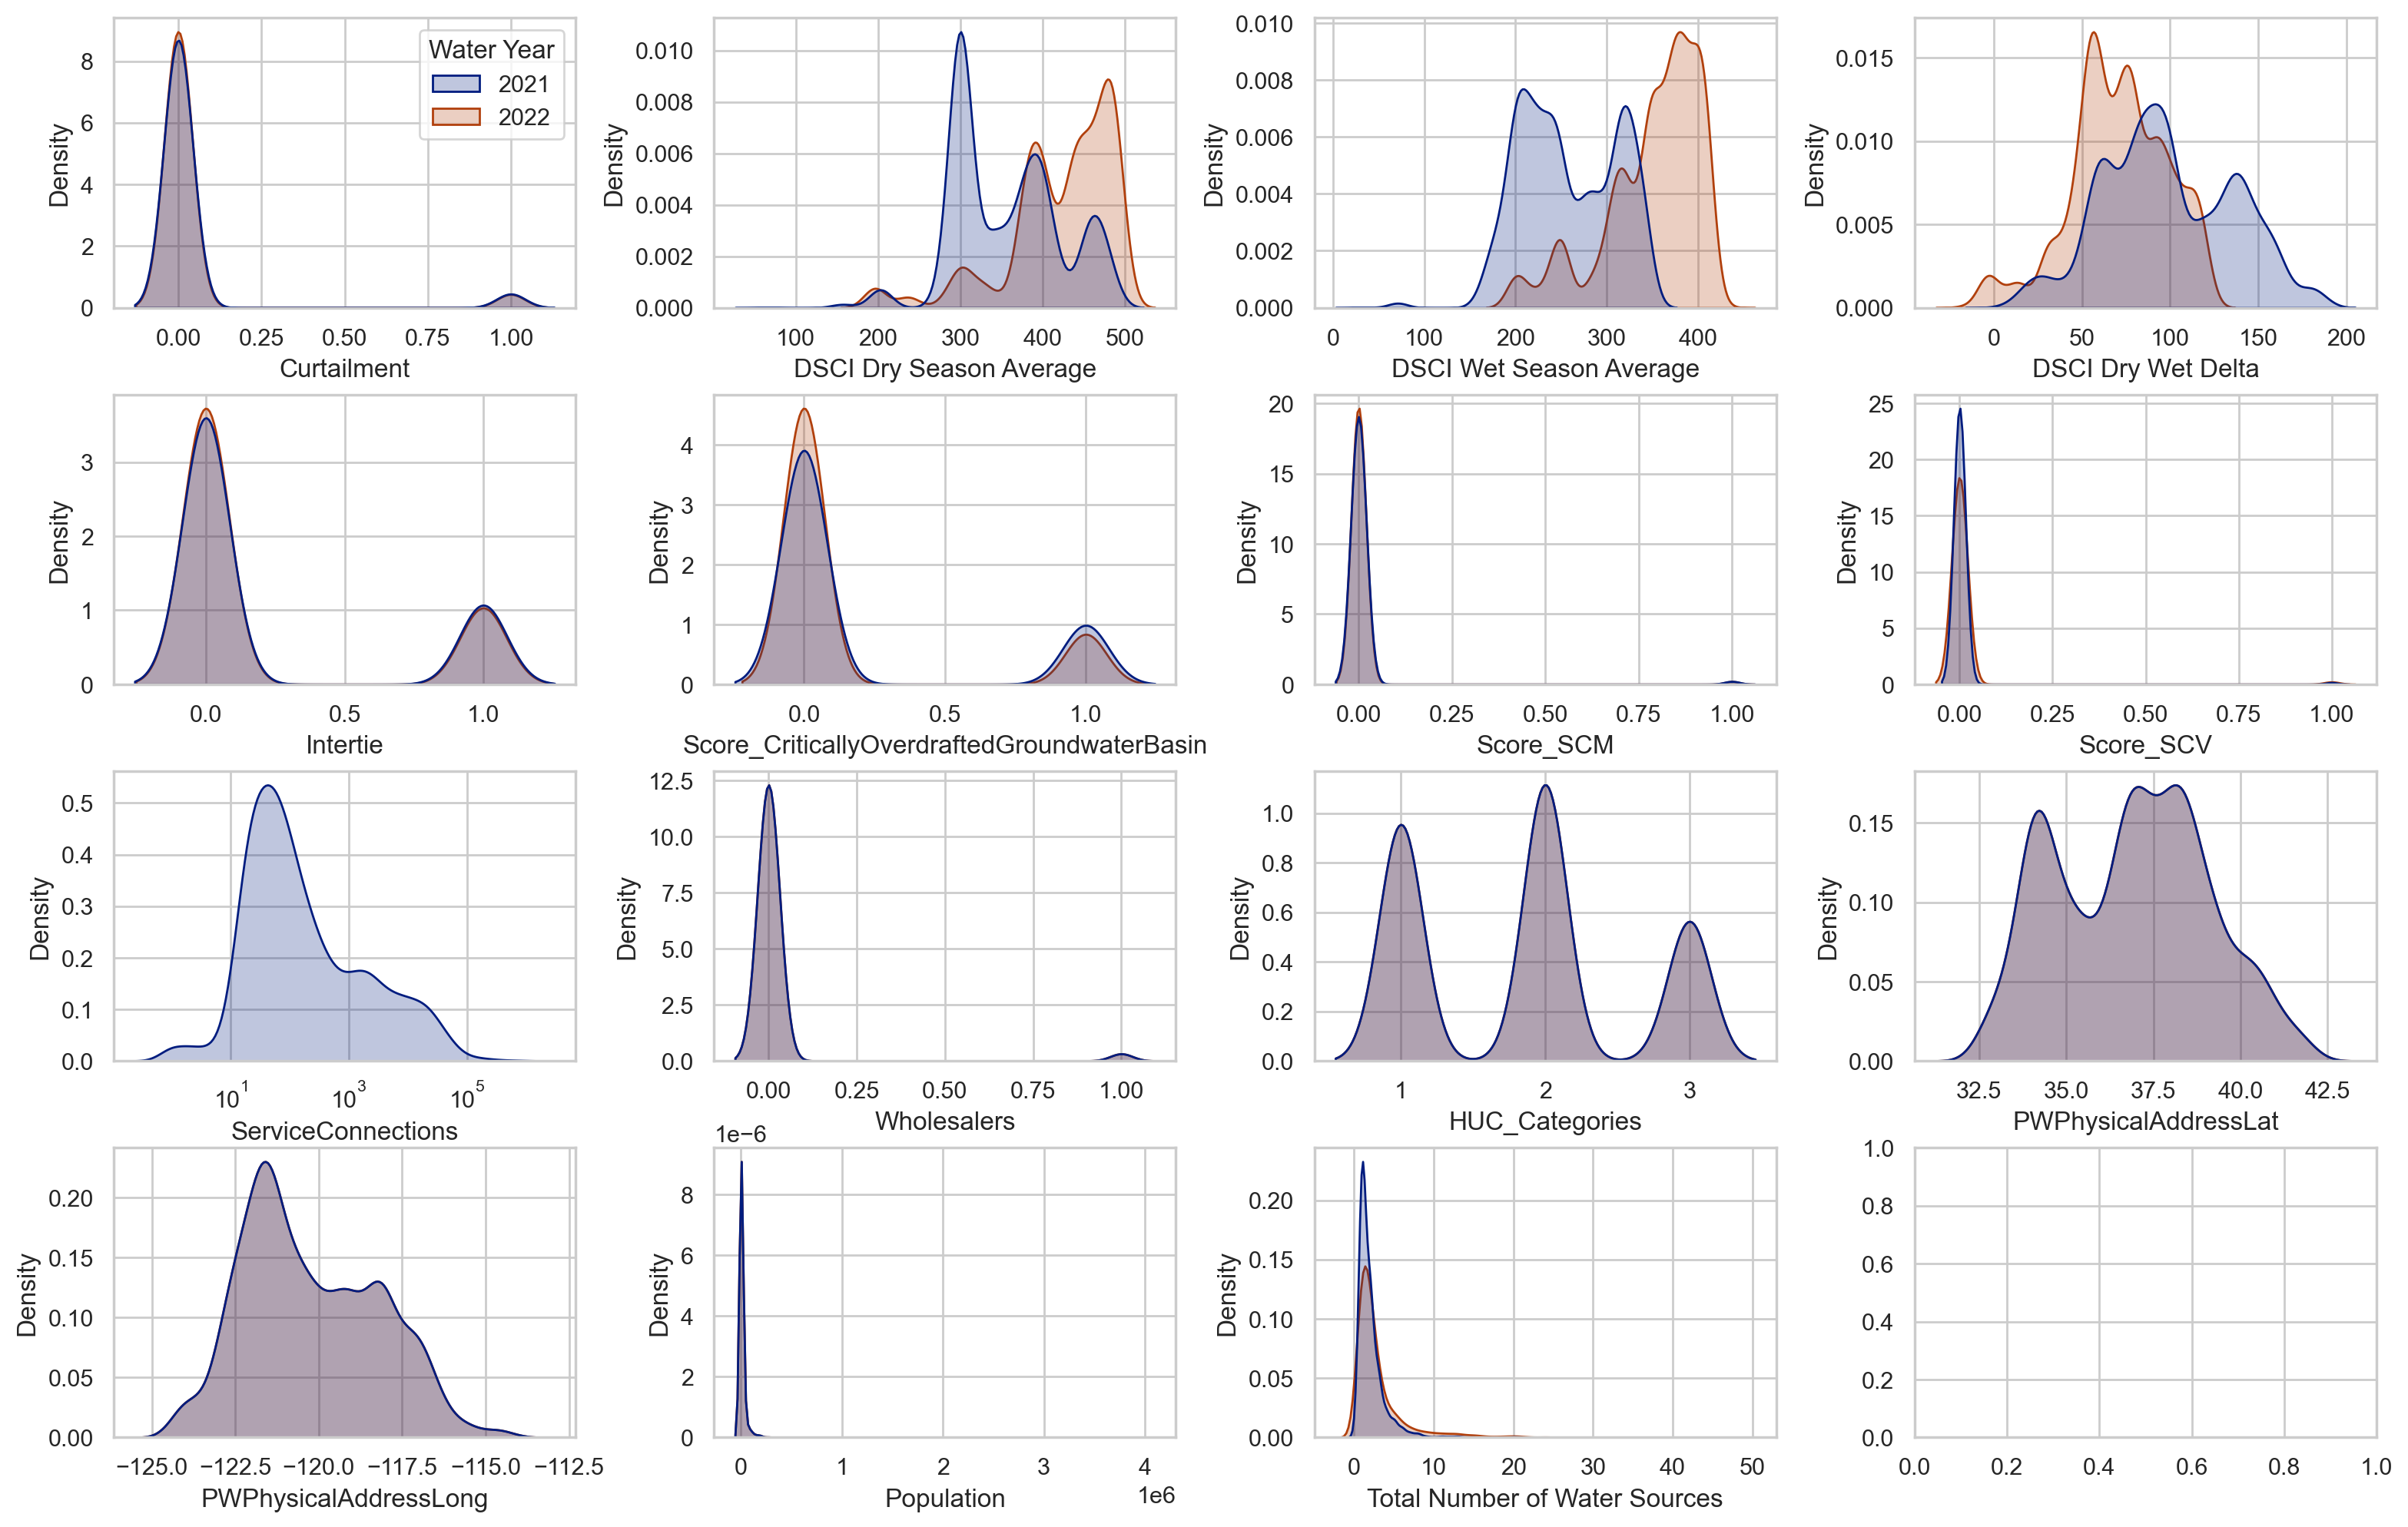

In [166]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(4,4, figsize=(19,12))
sns.kdeplot(df_combined, x='Curtailment', hue='Water Year', fill=True, ax=ax[0,0], legend=True, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Dry Season Average', hue='Water Year', fill=True, ax=ax[0,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Wet Season Average', hue='Water Year', fill=True, ax=ax[0,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Dry Wet Delta', hue='Water Year', fill=True, ax=ax[0,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Intertie', hue='Water Year', fill=True, ax=ax[1,0], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_CriticallyOverdraftedGroundwaterBasin', hue='Water Year', fill=True, ax=ax[1,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_SCM', hue='Water Year', fill=True, ax=ax[1,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_SCV', hue='Water Year', fill=True, ax=ax[1,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='ServiceConnections', hue='Water Year', fill=True, ax=ax[2,0], legend=False, log_scale=True, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Wholesalers', hue='Water Year', fill=True, ax=ax[2,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='HUC_Categories', hue='Water Year', fill=True, ax=ax[2,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='PWPhysicalAddressLat', hue='Water Year', fill=True, ax=ax[2,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='PWPhysicalAddressLong', hue='Water Year', fill=True, ax=ax[3,0], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Population', hue='Water Year', fill=True, ax=ax[3,1], legend=False, palette='dark')
sns.kdeplot(df_combined, x='Total Number of Water Sources', hue='Water Year', fill=True, ax=ax[3,2], legend=False, palette='dark')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#fig.savefig('Features_per_WaterYear.png', dpi=300, transparent=True, bbox_inches='tight')

**Thinking about the label**

To include:
* `BottledHauledWaterOrZeroSource`: This describes whether a system currently relies on bottled water. 
* `Score_1702`: This is a self-reported label that indicates whether a CWS experienced drought-related issues. This is submitted by form from CWSs to the DDW. This seems important to include.
* `WaterOutageDroughtViolation`: This directly describes whether a system had an outage due to drought.

To exclude:
* `FundedProject`: This describes whether a CWS applied for funding. As previously discussed, it does not relate directly to drought or outages and reduces the performance of the model. Eliminate this portion of the label.

A closer look at `Curtailment` and `CurtailmentExemptionPetition`:
* `Curtailment`: A curtailment occurs when there is already a problem. According to the [DDW 2022 Water Right Curtailments Fact Sheet](https://www.waterboards.ca.gov/drought/resources-for-water-rights-holders/docs/curtailments-2022.pdf): "State Water Board staff evaluate water availability using current and forecasted hydrologic information, water use data from water right holders, environmental water needs, projected supplies, and more. When that evaluation shows there is not enough water to support all the known needs in a watershed, the State Water Board can send water right holders an order that prohibits water use. These orders are called Curtailment Orders." Based on this, it seems like `Curtailment` should be an outcome. 
* `CurtailmentExemptionPetition`: This is a petition to repeal the curtailment and unrelated to drought. The only ones who would appeal a curtailment are those who are already curtailed.

Look at the keyword : 

<Axes: xlabel='CurtailmentExemptionPetition', ylabel='Density'>

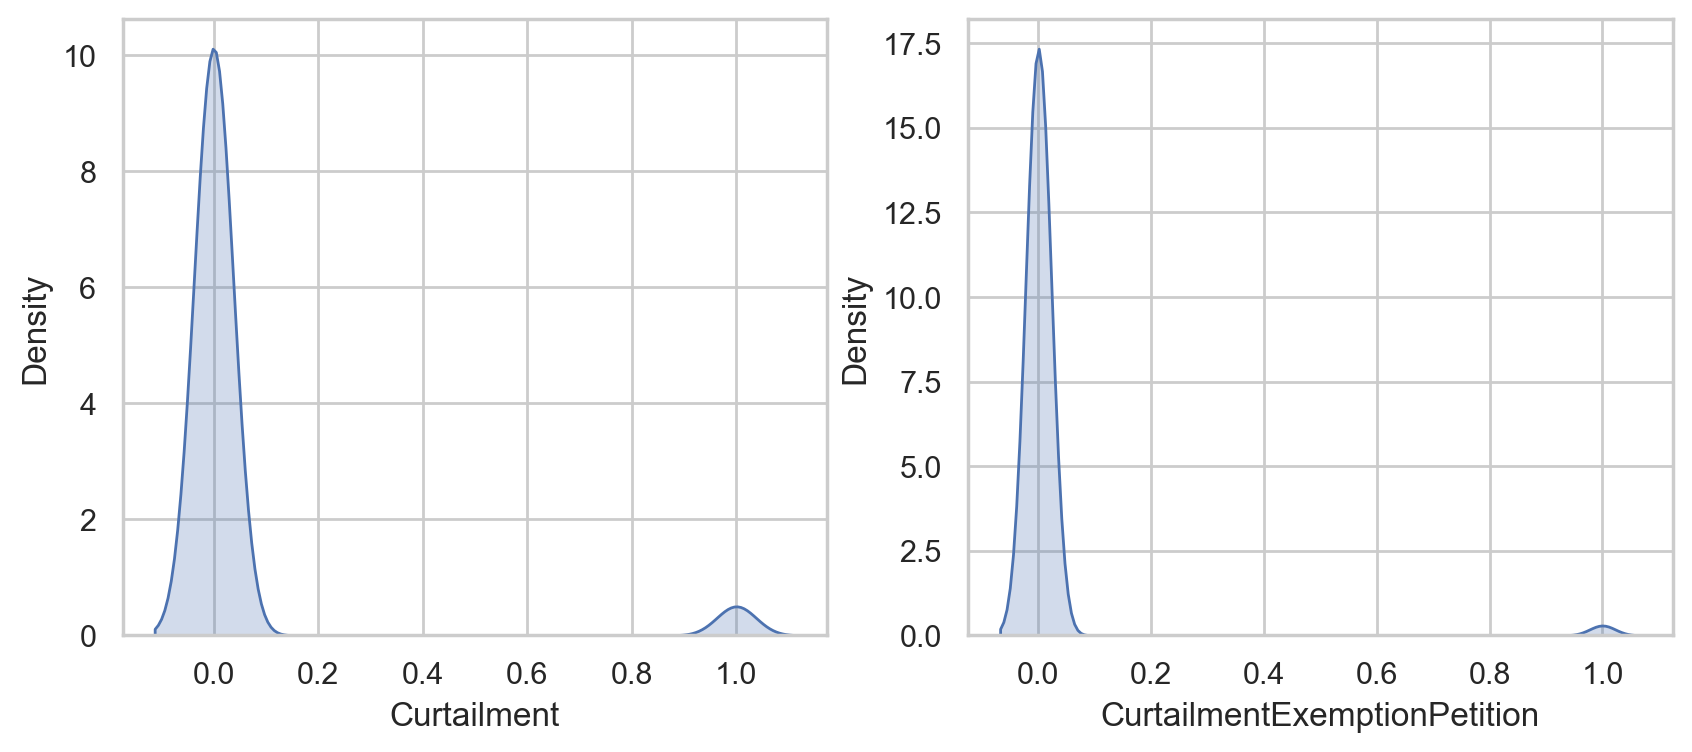

In [167]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.kdeplot(x=df_combined['Curtailment'], fill=True, legend=True, ax=ax[0])
sns.kdeplot(x=df_combined['CurtailmentExemptionPetition'], fill=True, legend=True, ax=ax[1])

In [168]:
print('Number of Curtailments in 2021: ',df_combined[df_combined['Water Year'] == 2021]['Curtailment'].value_counts()[1])
print('Number of Petitions in 2021: ',df_combined[df_combined['Water Year'] == 2021]['CurtailmentExemptionPetition'].value_counts()[1])
print('Number of Curtailments in 2022: ',df_combined[df_combined['Water Year'] == 2022]['Curtailment'].value_counts()[1])
print('Number of Petitions in 2022: ',df_combined[df_combined['Water Year'] == 2022]['CurtailmentExemptionPetition'].value_counts()[1])

Number of Curtailments in 2021:  139
Number of Petitions in 2021:  42
Number of Curtailments in 2022:  131
Number of Petitions in 2022:  53


Are there people who did not experience outages who wanted a petition?

In [169]:
df_combined[df_combined['CurtailmentExemptionPetition'] == 1][['BottledHauledWaterOrZeroSource', 'WaterOutageDroughtViolation', 'Score_1702','Curtailment']]

,BottledHauledWaterOrZeroSource,WaterOutageDroughtViolation,Score_1702,Curtailment
24,0,0,0.0,1
78,0,0,0.0,1
169,0,0,0.0,1
173,0,0,0.0,1
249,0,0,0.0,1
616,0,0,0.0,1
619,0,0,0.0,1
643,0,0,0.0,1
672,0,0,0.0,1
963,0,0,0.0,1


Look at the difference in the labels between 2021 and 2022.

In [170]:
print('Year 2021')
print('Positive values of DroughtExperienced: ',df_combined[df_combined['Water Year'] == 2021]['DroughtExperienced'].value_counts()[1])
print('Positive values of WaterOutageDroughtViolation: ',df_combined[df_combined['Water Year'] == 2021][['WaterOutageDroughtViolation']].value_counts()[1])
print('Positive values| of BottledHauledWaterOrZeroSource: ',df_combined[df_combined['Water Year'] == 2021][['BottledHauledWaterOrZeroSource']].value_counts()[1])
print('Positive values of CurtailmentExemptionPetition: ',df_combined[df_combined['Water Year'] == 2021][['CurtailmentExemptionPetition']].value_counts()[1])
print('Positive values of FundedProject: ',df_combined[df_combined['Water Year'] == 2021][['FundedProject']].value_counts()[1])
print('Positive values of FundedProject: ',df_combined[df_combined['Water Year'] == 2021][['Score_1702']].value_counts()[1])

Year 2021
Positive values of DroughtExperienced:  183
Positive values of WaterOutageDroughtViolation:  16
Positive values| of BottledHauledWaterOrZeroSource:  58
Positive values of CurtailmentExemptionPetition:  42
Positive values of FundedProject:  62
Positive values of FundedProject:  41


In [171]:
print('Year 2022')
print('Positive values of DroughtExperienced: ',df_combined[df_combined['Water Year'] == 2022][['DroughtExperienced']].value_counts()[1])
print('Positive values of WaterOutageDroughtViolation: ',df_combined[df_combined['Water Year'] == 2022][['WaterOutageDroughtViolation']].value_counts()[1])
print('Positive values of BottledHauledWaterOrZeroSource: ',df_combined[df_combined['Water Year'] == 2022][['BottledHauledWaterOrZeroSource']].value_counts()[1])
print('Positive values of CurtailmentExemptionPetition: ',df_combined[df_combined['Water Year'] == 2022][['CurtailmentExemptionPetition']].value_counts()[1])
print('Positive values of FundedProject: ',df_combined[df_combined['Water Year'] == 2022][['FundedProject']].value_counts()[1])
print('Positive values of FundedProject: ',df_combined[df_combined['Water Year'] == 2022][['Score_1702']].value_counts()[1])
print('Positive values of FundedProject: ',df_combined[df_combined['Water Year'] == 2022][['Score_1704']].value_counts()[1])

Year 2022
Positive values of DroughtExperienced:  276
Positive values of WaterOutageDroughtViolation:  3
Positive values of BottledHauledWaterOrZeroSource:  66
Positive values of CurtailmentExemptionPetition:  53
Positive values of FundedProject:  91
Positive values of FundedProject:  70
Positive values of FundedProject:  59


In [172]:
total = [
    df_combined[df_combined['Water Year'] == 2021][['DroughtExperienced']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['WaterOutageDroughtViolation']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['BottledHauledWaterOrZeroSource']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['CurtailmentExemptionPetition']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['FundedProject']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['Score_1702']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['Score_1704']].value_counts()[1],    
    df_combined[df_combined['Water Year'] == 2022][['DroughtExperienced']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['WaterOutageDroughtViolation']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['BottledHauledWaterOrZeroSource']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['CurtailmentExemptionPetition']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['FundedProject']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['Score_1702']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['Score_1704']].value_counts()[1]]    

In [173]:
year = [2021, 2021, 2021, 2021, 2021, 2021, 2021,
        2022, 2022, 2022, 2022, 2022, 2022, 2022]

In [174]:
labels = ['DroughtExperienced', 'WaterOutageDroughtViolation', 'BottledHauledWaterOrZeroSource', 
          'CurtailmentExemptionPetition', 'FundedProject', 'Score_1702', 'Score_1704',
          'DroughtExperienced', 'WaterOutageDroughtViolation', 'BottledHauledWaterOrZeroSource', 
          'CurtailmentExemptionPetition', 'FundedProject', 'Score_1702', 'Score_1704']

In [175]:
df_examples = pd.DataFrame(
    {'Total': total,
     'Year': year,
     'Labels': labels})

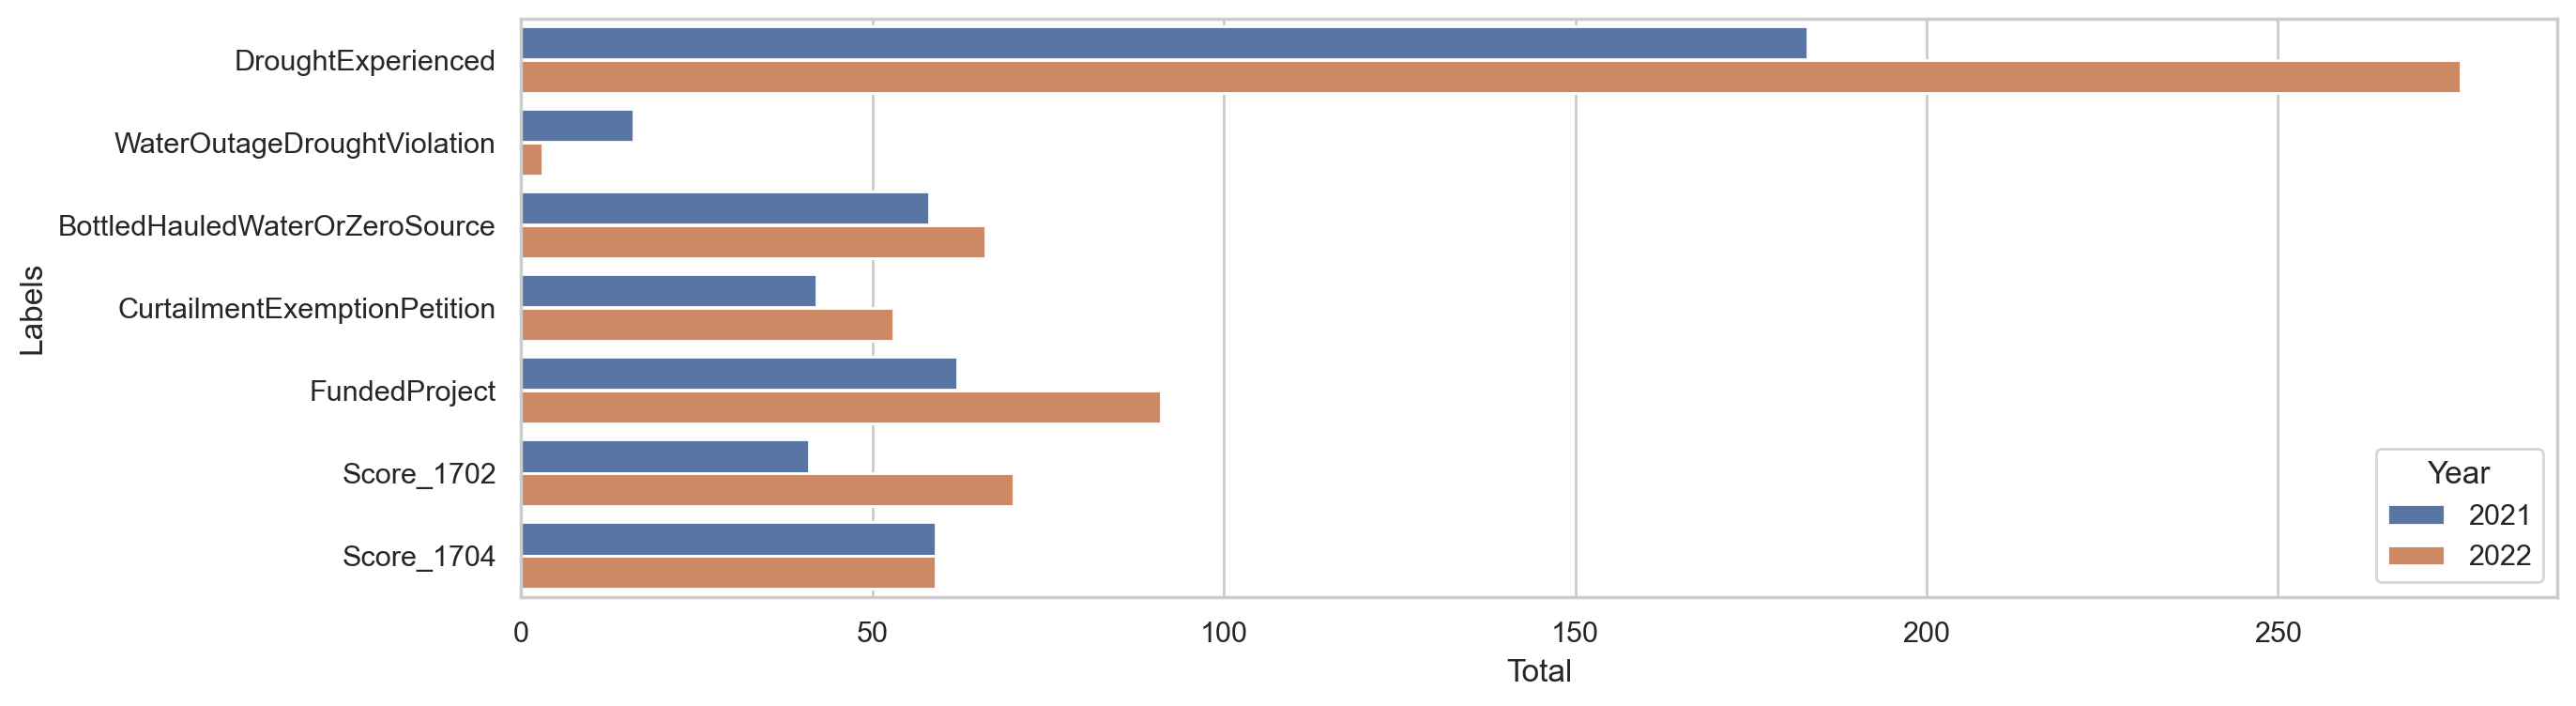

In [176]:
fig, ax = plt.subplots(figsize=(14,4))
sns.set_theme(style='whitegrid')

sns.barplot(orient="h", data=df_examples, x='Total', y='Labels', hue='Year')
fig.savefig('outcome.png', dpi=300, transparent=True, bbox_inches='tight')

Look at the features together with the each consituent outcome label.

Right now, the outcome label `DroughtExperienced` equals 1 if any of the following consituent outcomes equal 1:  `WaterOutageDroughtViolation'`, `BottledHauledWaterOrZeroSource`, `CurtailmentExemptionPetition`, `Score_1704`, `FundedProject`. Otherwise, `DroughtExperienced` equals zero.

/var/folders/93/hbnl0wps0mg_sqnmv_jpnwlm0000gq/T/ipykernel_13720/1445186735.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

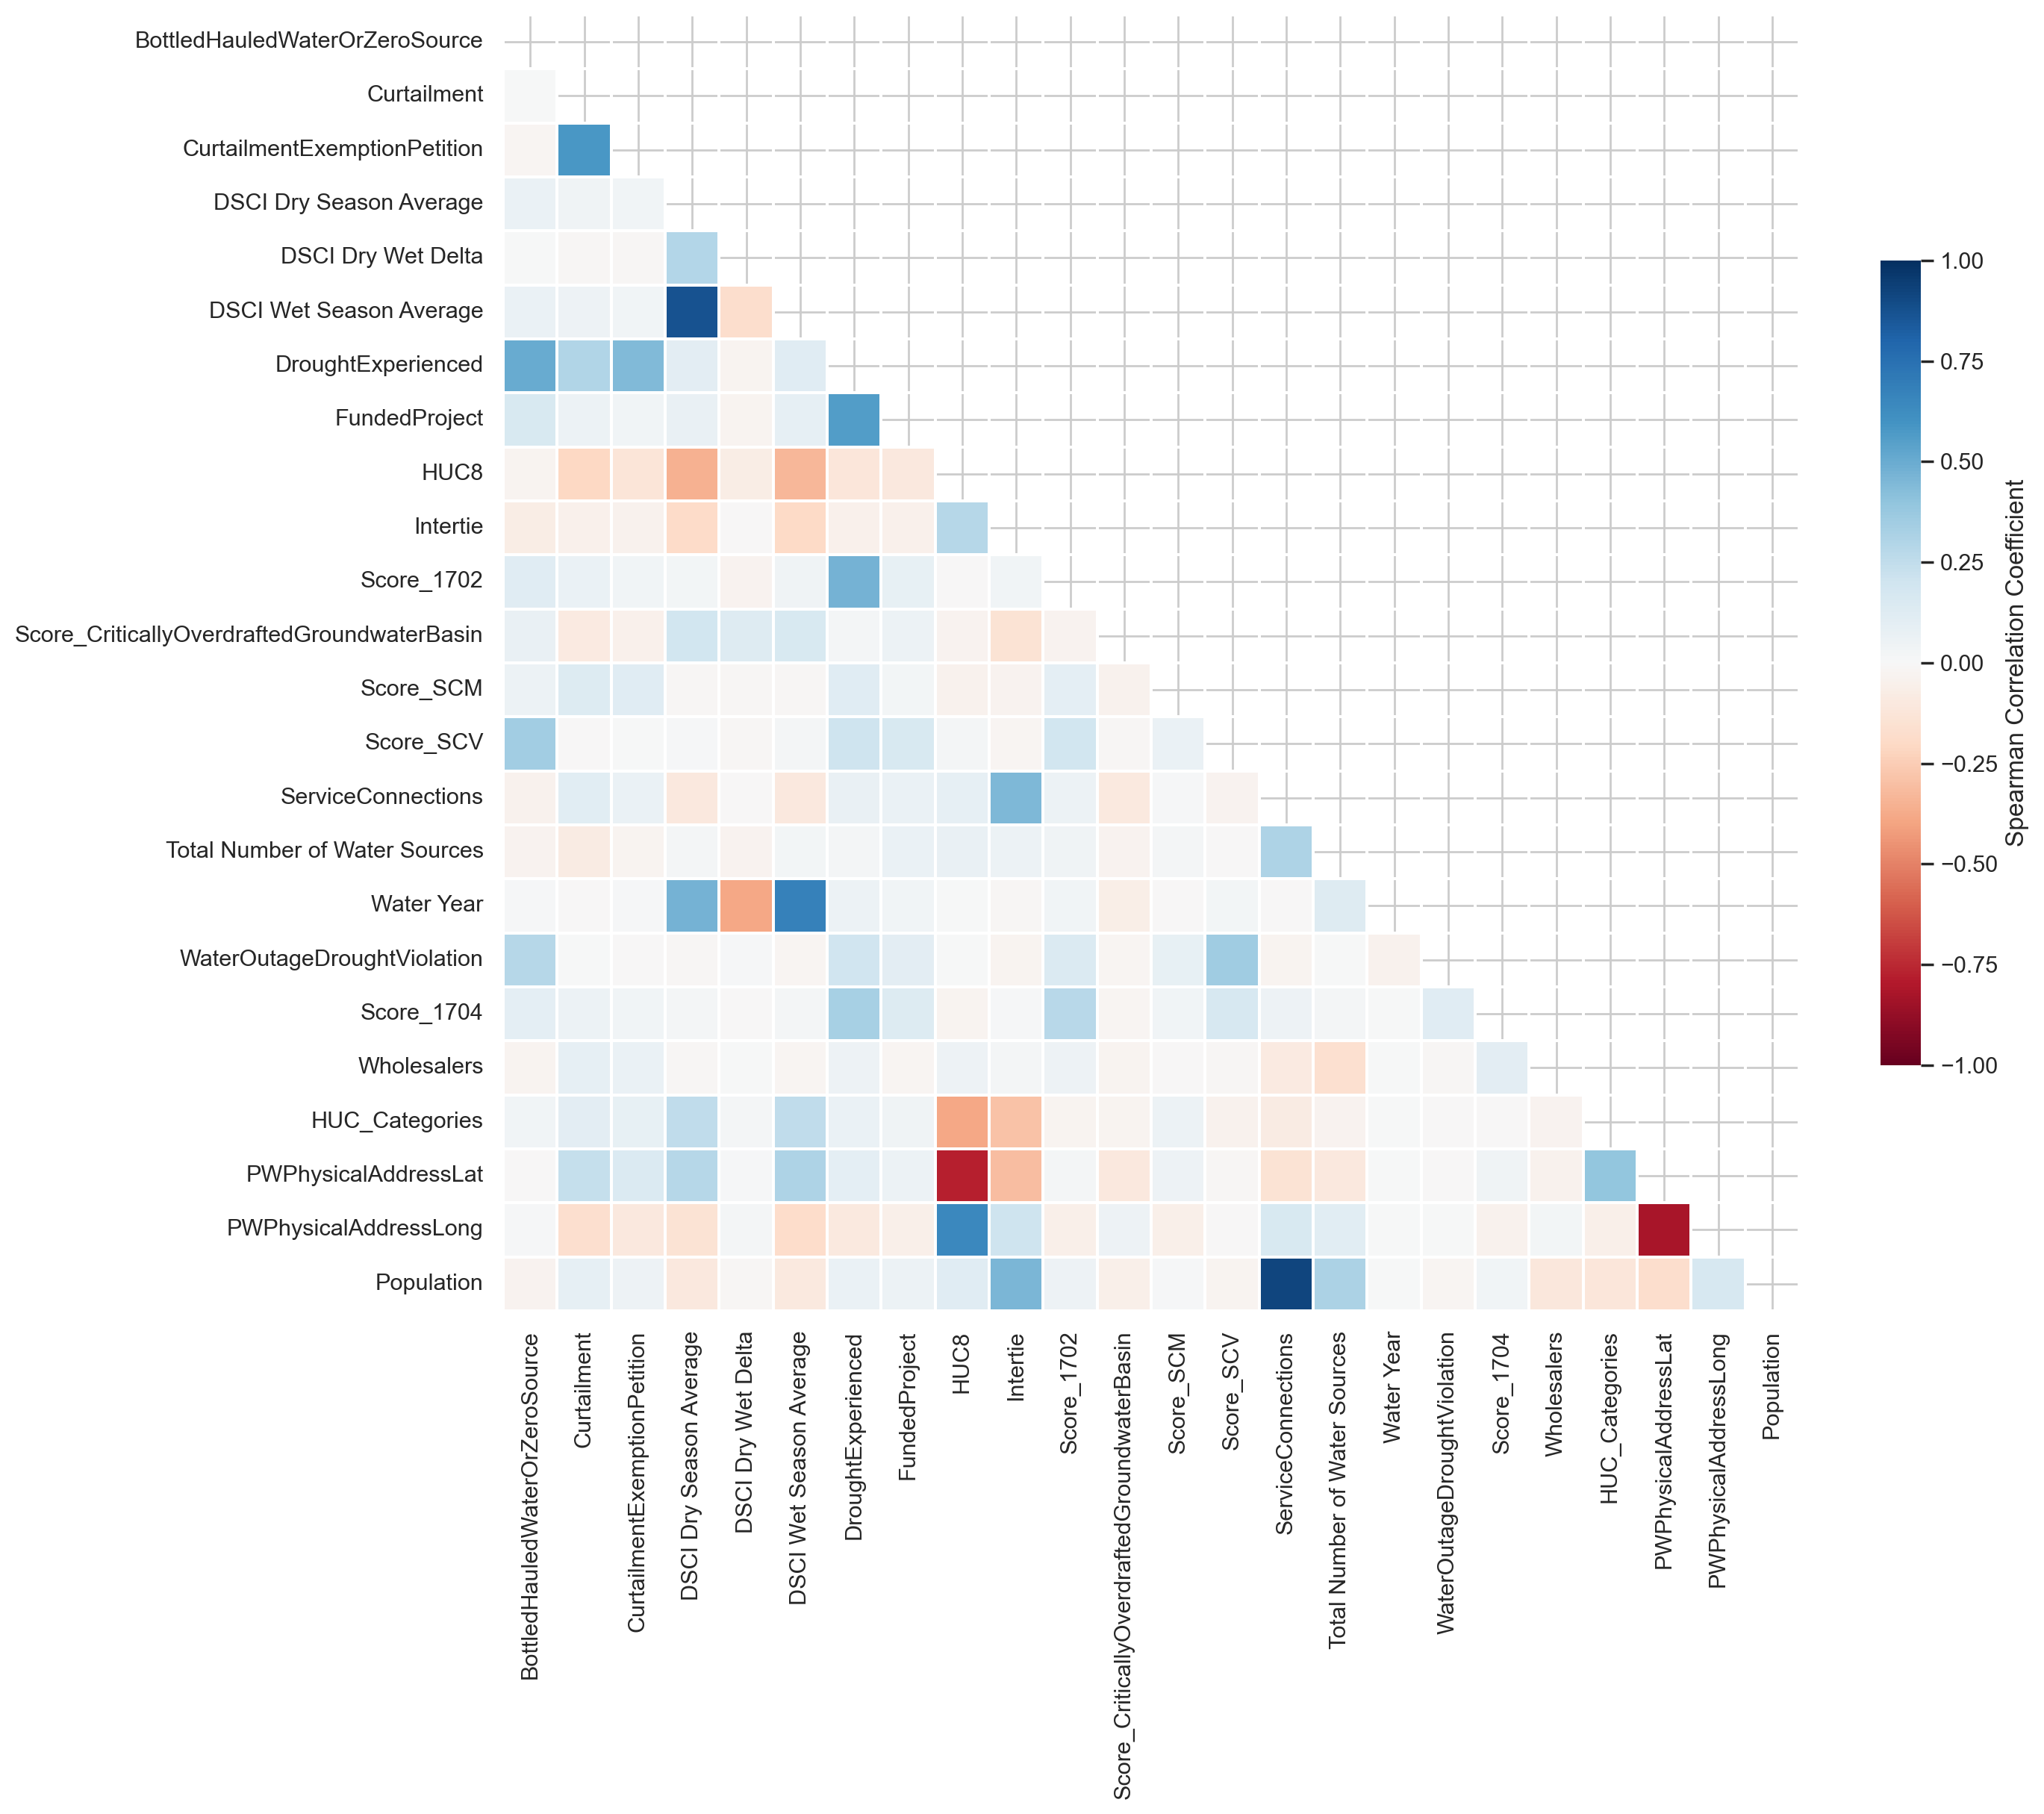

In [177]:
fig, ax = plt.subplots(figsize=(14, 14))
sns.set_theme(style="white")

# Calculate Spearman correlation coefficient
corr = df_combined.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot Spearman correlation coefficient as a diagonal heatmap
cmap = sns.color_palette('RdBu', as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.75, cbar_kws={"shrink": .5, "label": 'Spearman Correlation Coefficient'})
#fig.savefig('spearman_with_labels_v4.png', dpi=300, transparent=True, bbox_inches='tight')

### Split the data

Split the data into a training and a validation set.

In [178]:
numeric_features = ['ServiceConnections', 'Population',
                    'PWPhysicalAddressLat', 'PWPhysicalAddressLong', 
                    'DSCI Dry Season Average', 'DSCI Wet Season Average',
                    'DSCI Dry Wet Delta', 'Total Number of Water Sources']

categorical_features = ['Score_SCV', 'Score_SCM',
                        'Score_CriticallyOverdraftedGroundwaterBasin',
                        'Intertie', 'Wholesalers',
                        'Curtailment', 'HUC_Categories']

all_features = numeric_features + categorical_features

In [179]:
# Use 2021 as the training data and 2022 as the testing data
training_index = df_combined[df_combined['Water Year'] == 2021].index
validation_index = df_combined[df_combined['Water Year'] == 2022].index

In [180]:
y = df_combined['DroughtExperienced']
X = df_combined[all_features]

X_train = X.loc[training_index]
X_val = X.loc[validation_index]
y_train = y.loc[training_index]
y_val = y.loc[validation_index]

print(f"The training set is {len(X_train)/len(X)*100}% of the data.")
print(f"The validation set is {len(X_val)/len(X)*100}% of the data.")

The training set is 50.0% of the data.
The validation set is 50.0% of the data.


### Scale the data

Scale the numeric features assuming the data obey a Gaussian distribution. Leave the categorical features unscaled.

In [181]:
if (len(numeric_features) + len(categorical_features)) == len(X.columns):
    print('All variables are included.')

All variables are included.


Select and scale the numeric features.

In [182]:
scaler = preprocessing.StandardScaler()

X_train_numeric = X_train[numeric_features]
X_val_numeric = X_val[numeric_features]

Scale the validation set using the same mean and variance as the training set.

In [183]:
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

Append the unscaled categorical features.

In [184]:
X_train_categorical = np.array(X_train[categorical_features])
X_val_categorical = np.array(X_val[categorical_features])

X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)

X_train_scaled.shape, X_val_scaled.shape

((2866, 15), (2866, 15))

### Train the model

We use a Gradient Boosting Trees to train and test the model. Note that the class imbalance ratio here is roughly 1:20.
We choose Cohen's Kappa Score as an validation metric.

In [185]:
# Print the number of examples per label in the training set
y_train.value_counts()

0    2683
1     183
Name: DroughtExperienced, dtype: int64

In [186]:
# Print the number of examples per label in the validation set
y_val.value_counts()

0    2590
1     276
Name: DroughtExperienced, dtype: int64

In [187]:
# Initialize the model
n_estimators = 100
clf = GradientBoostingClassifier(n_estimators=n_estimators)

# Fit the model
sample_weight = np.zeros(len(y_val))
sample_weight[y_val == 0] = 1
sample_weight[y_val == 1] = i
model = clf.fit(X_train_scaled, y_train, sample_weight=sample_weight)

In [188]:
# Predict the outcome with the best estimator
y_pred = y_pred = clf.predict(X_val_scaled)
y_pred_probability = clf.predict_proba(X_val_scaled)

### Question 1: Does the model perform well?

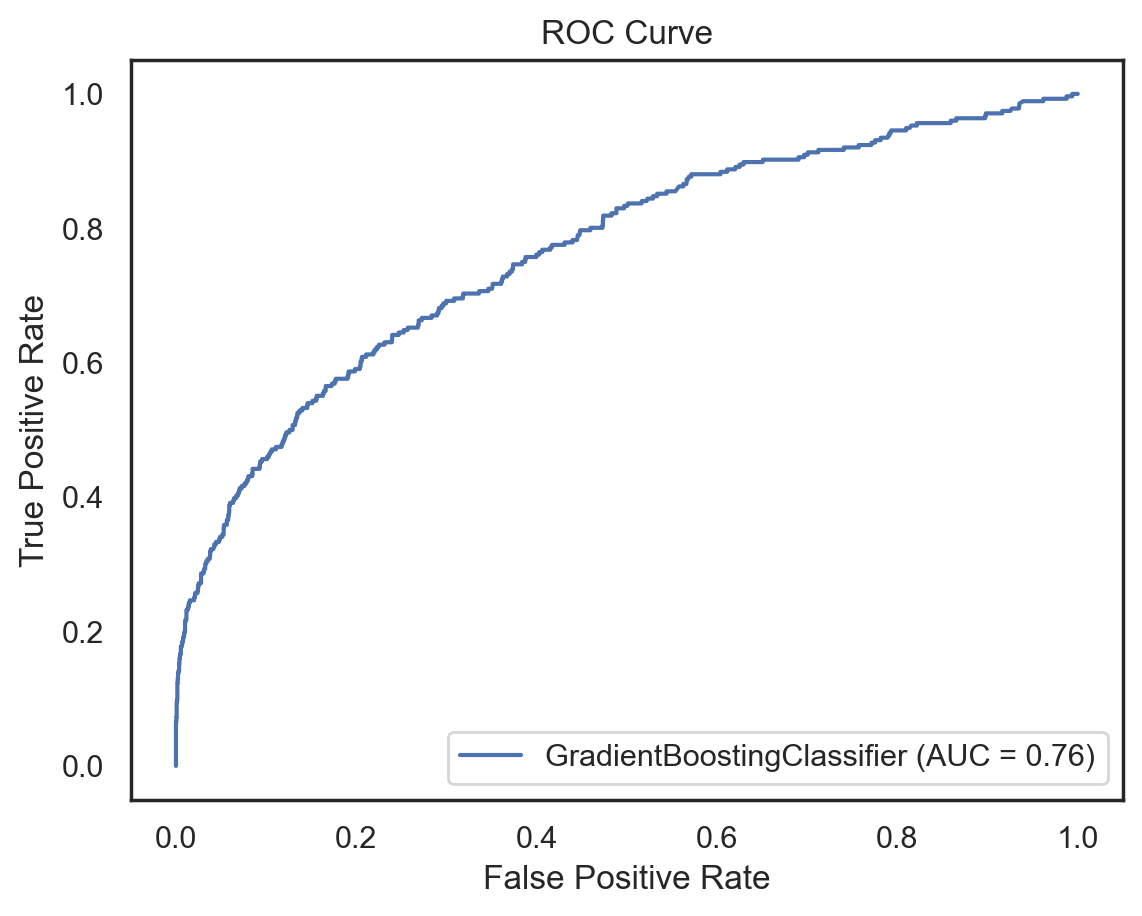

In [189]:
fig, ax = plt.subplots()
rfc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_val_scaled, y_val, ax=ax, response_method='predict_proba')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
plt.show()
#fig.savefig('ROC_AUC.png', dpi=300, transparent=True, bbox_inches='tight')

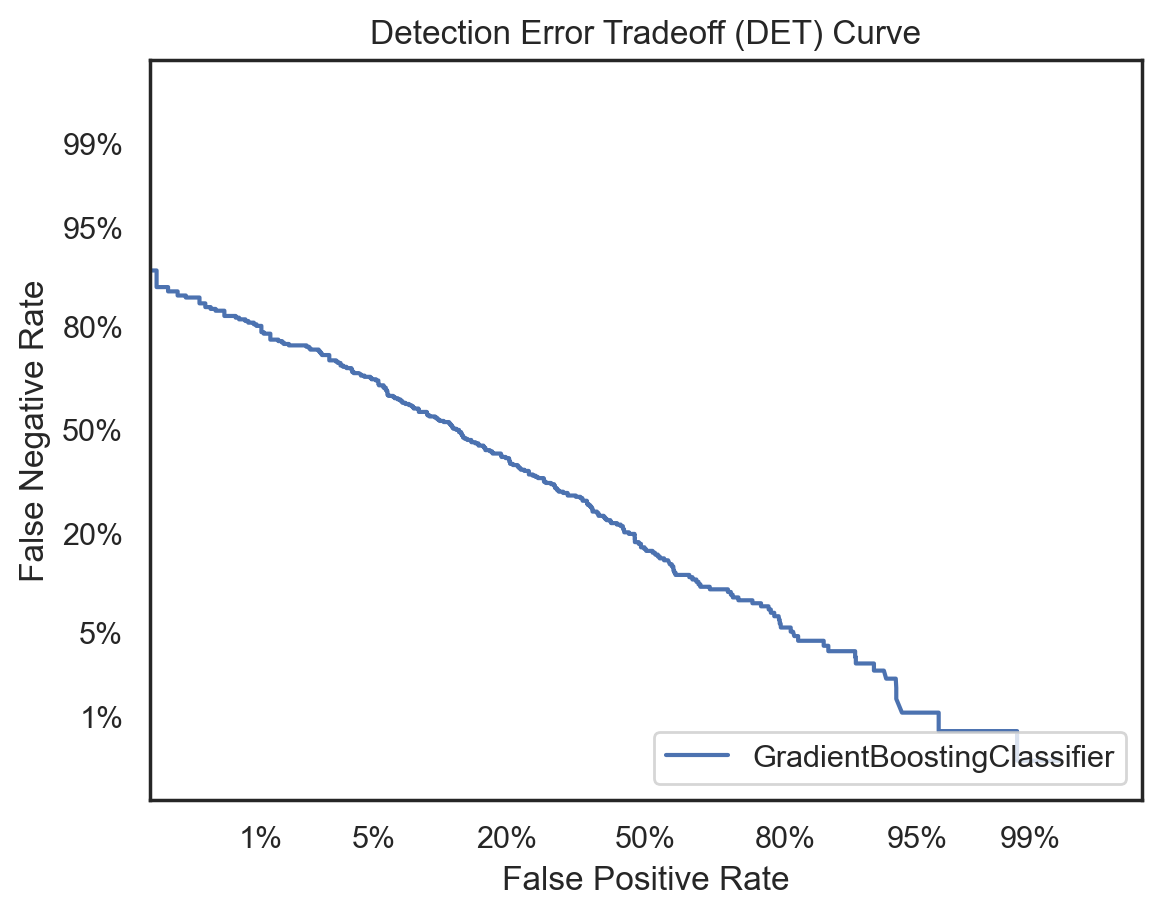

In [190]:
fig, ax = plt.subplots()
rfc_disp = metrics.DetCurveDisplay.from_estimator(clf, X_val_scaled, y_val, ax=ax, response_method='predict_proba')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('Detection Error Tradeoff (DET) Curve')
plt.show()
#fig.savefig('DET_2022.png', dpi=300, transparent=True, bbox_inches='tight')

Print the probabilities per CWS:

In [191]:
y_val_np = np.array(y_val)

In [192]:
count_false_positive = 0
count_false_negative = 0
for i in range(len(y_val_np)):
    if ((y_val_np[i] == 0) and (y_pred_probability[i][0] <= 0.5)):
        count_false_positive += 1
        print('CWS {}: False Positive. True Value = {}, Probability of 0 = {}, Probability of 1 = {}.'.format(df_combined.loc[training_index][['CWSID']].iloc[i][0], y_val_np[i], y_pred_probability[i][0], y_pred_probability[i][1]))
    if ((y_val_np[i] == 1) and (y_pred_probability[i][1] <= 0.5)):
        print(i)
        print('CWS {}: False Negative. True Value = {}, Probability of 0 = {}, Probability of 1 = {}.'.format(df_combined.loc[training_index][['CWSID']].iloc[i][0], y_val_np[i], y_pred_probability[i][0], y_pred_probability[i][1]))
print('There were {} false positives.'.format(count_false_positive))
print('There were {} false negatives.'.format(count_false_negative))

CWS CA0103041: False Positive. True Value = 0, Probability of 0 = 0.4505351253203126, Probability of 1 = 0.5494648746796874.
3
CWS CA0110001: False Negative. True Value = 1, Probability of 0 = 0.6980031397838424, Probability of 1 = 0.3019968602161576.
CWS CA0110016: False Positive. True Value = 0, Probability of 0 = 0.3009787566632268, Probability of 1 = 0.6990212433367732.
15
CWS CA0202504: False Negative. True Value = 1, Probability of 0 = 0.9524510575144399, Probability of 1 = 0.04754894248556012.
33
CWS CA0310006: False Negative. True Value = 1, Probability of 0 = 0.8529592570020627, Probability of 1 = 0.14704074299793732.
45
CWS CA0400012: False Negative. True Value = 1, Probability of 0 = 0.9618725941302119, Probability of 1 = 0.03812740586978815.
47
CWS CA0400014: False Negative. True Value = 1, Probability of 0 = 0.8546581336648645, Probability of 1 = 0.14534186633513546.
69
CWS CA0405001: False Negative. True Value = 1, Probability of 0 = 0.8113862294054887, Probability of 1 =

### Question 2: What are the most predictive features?

We assess predictive capacity based the Univariate F Score.

[Text(0.5, 0, 'Normalized Fisher Score')]

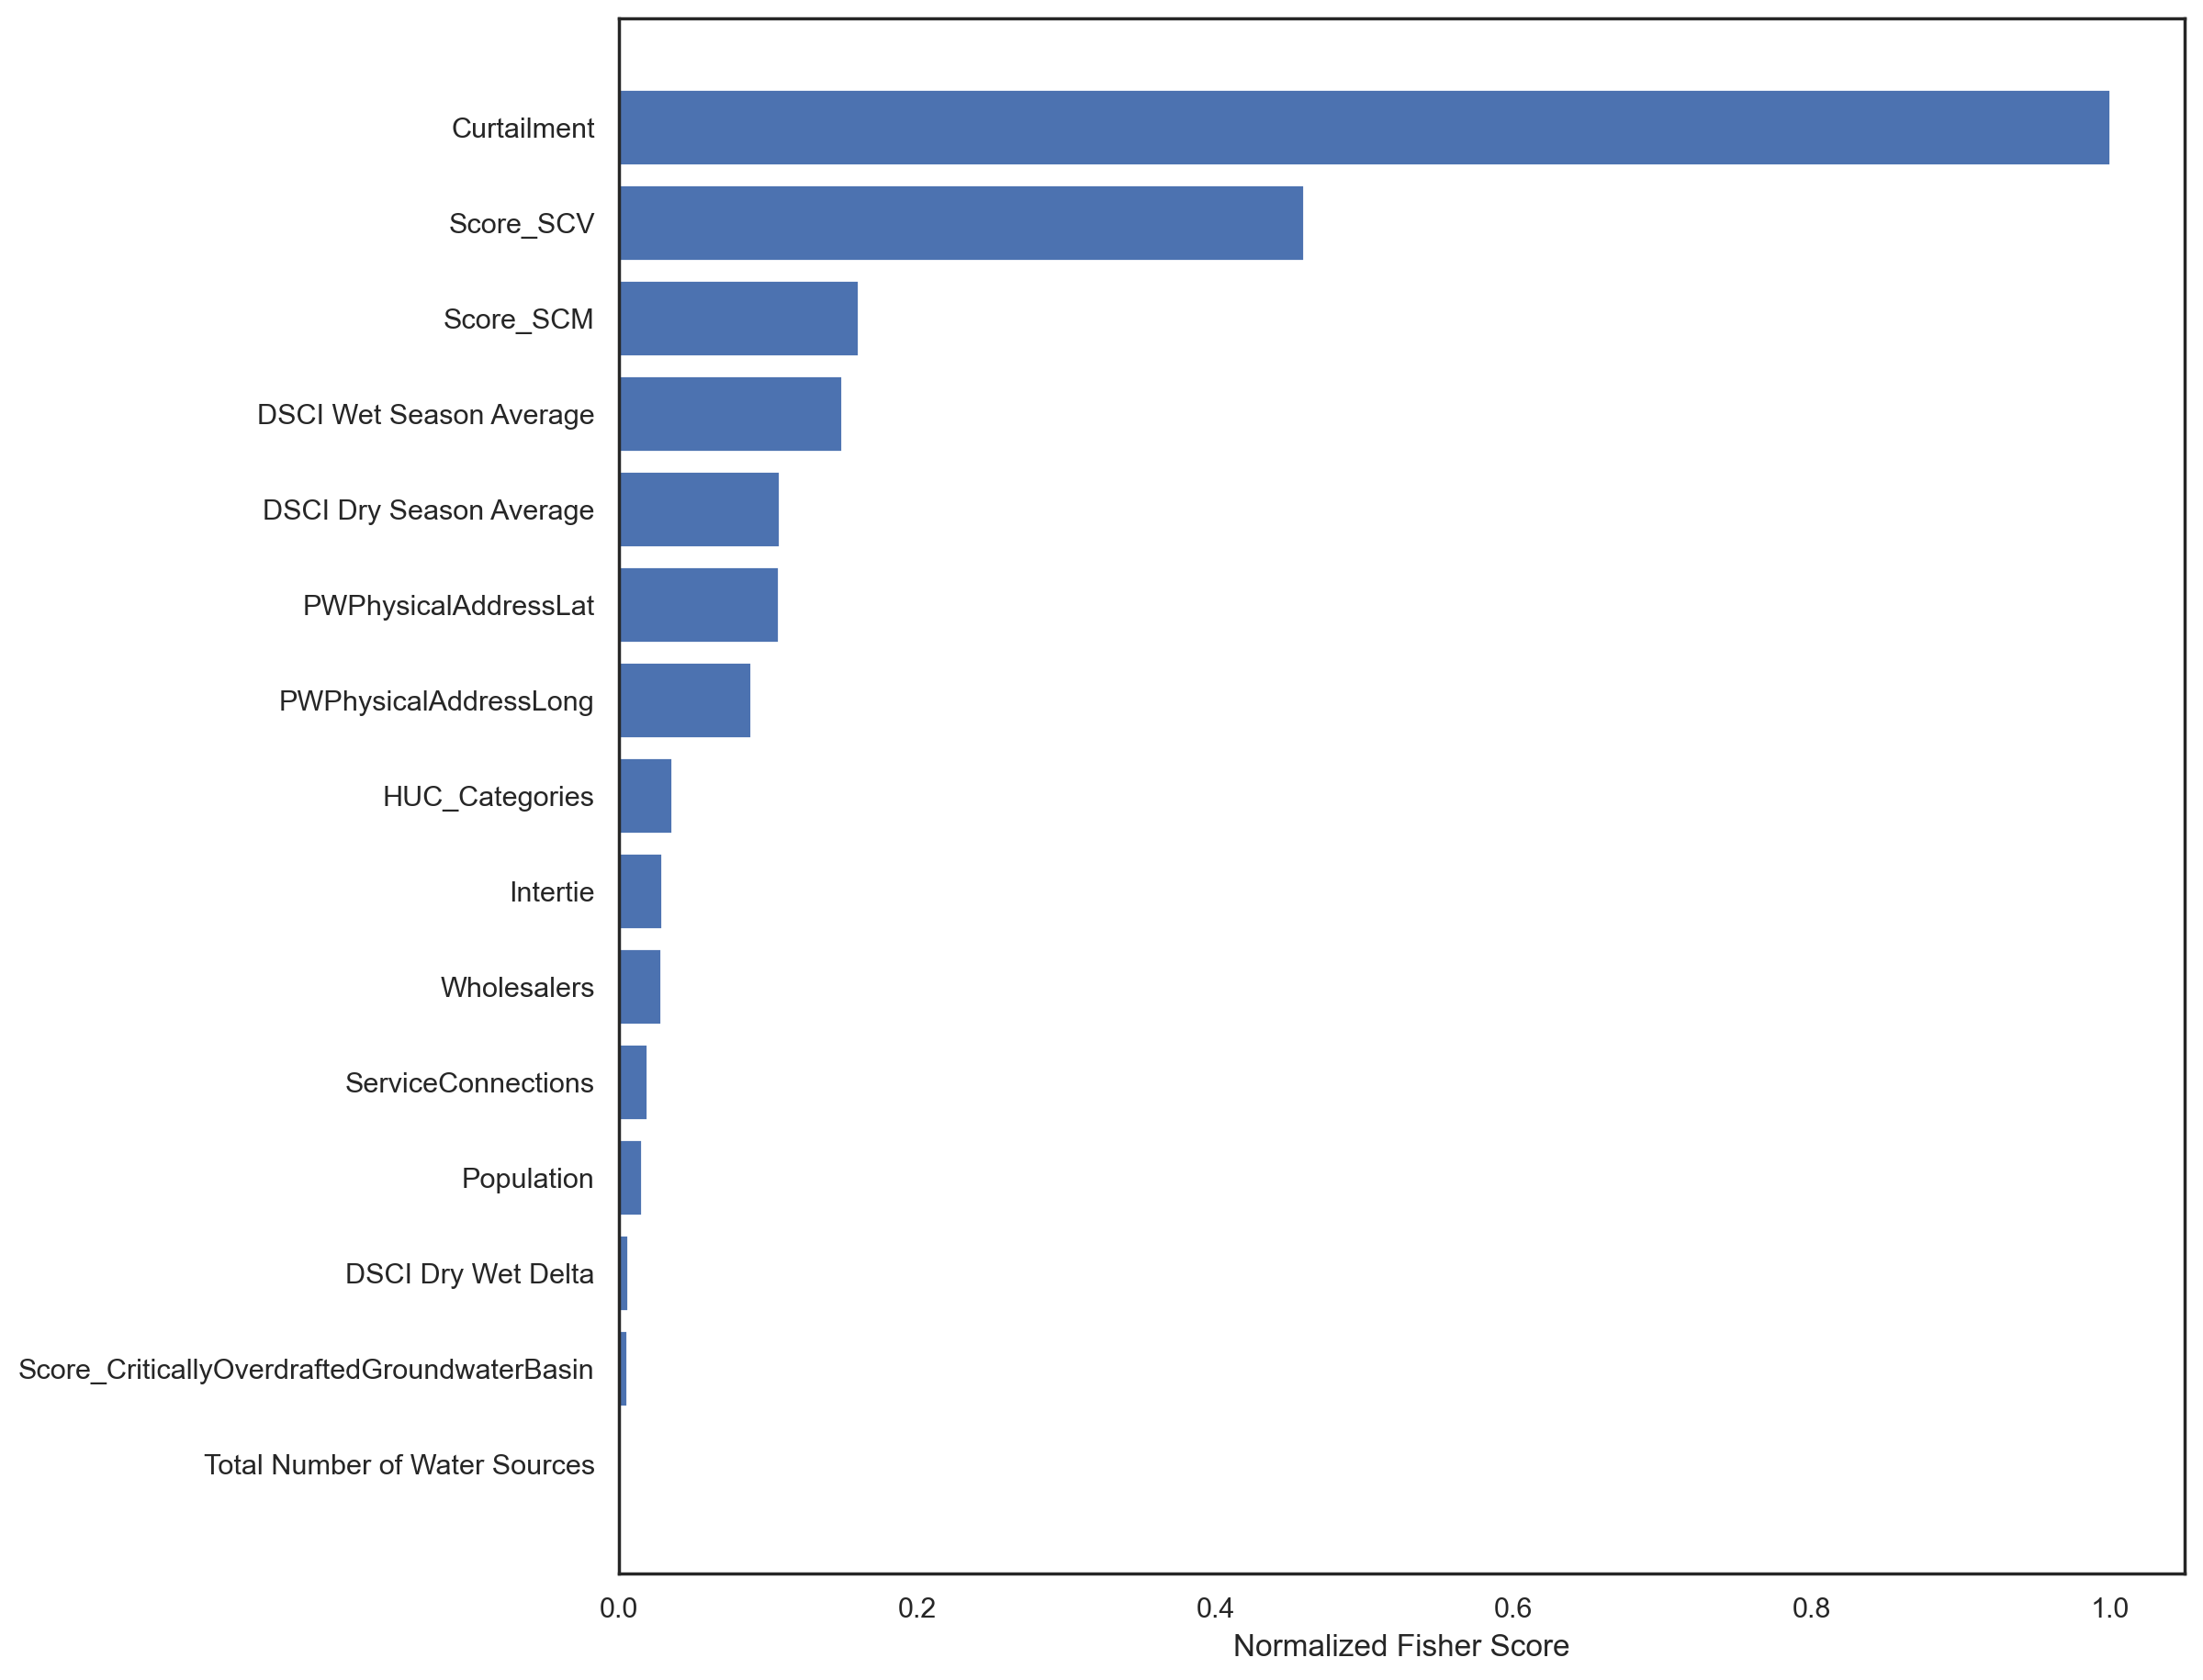

In [193]:
fig, ax = plt.subplots(figsize=(11,11))
sns.set_theme(style='whitegrid')

# Select method and fit
selector=SelectKBest(f_classif, k='all')
selector.fit(X, y)
scores_fisher = selector.scores_
scores_fisher[np.isnan(scores_fisher)] = 0.0

# Select, sort, and normalize features
features = X.columns.to_list()
order = np.argsort(scores_fisher)
ordered_features_fisher = [features[i] for i in order]
ordered_normalized_scores_fisher = sorted(scores_fisher/np.nanmax(scores_fisher))
ordered_scores_fisher = sorted(scores_fisher)

ax.barh(ordered_features_fisher, ordered_normalized_scores_fisher)
ax.set(xlabel = 'Normalized Fisher Score')
#fig.savefig('features.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 3: How does the false positive rate and false negative rate change as a function of class weight?

In [194]:
def test_sample_weights(n_estimators):
    
    # Convert validation labels into a numpy array
    y_val_np = np.array(y_val)
    
    # Create an empty dataframe
    out = [np.NaN]*50
    df_weight = pd.DataFrame({'n_estimators':out, 'weight':out,
                          'total_false_positives':out, 'total_false_negatives':out,
                          'total_misclassifications':out})
    
    # Define some counters
    count_misclassifications = 0
    count_false_positive = 0
    count_false_negative = 0
    count_true_positive = 0
    count_true_negative = 0
    total_counts = []
    total_false_positives = []
    total_false_negatives = []
    total_true_positives = []
    total_true_negatives = []
    weight = []

    print ("Number of estimators:", n_estimators)
    
    for i in range(1,100,2):
            
            # Define a counter
            location = int( ((i-1)/2) )
            df_weight['n_estimators'].iloc[location]=n_estimators
            df_weight['weight'].iloc[location] = i
            print("--> Sample weight:", i)

            # Initialize the model
            clf = GradientBoostingClassifier(n_estimators=n_estimators)

            # Fit the model
            sample_weight = np.zeros(len(y_val))
            sample_weight[y_val == 0] = 1
            sample_weight[y_val == 1] = i
            clf.fit(X_train_scaled, y_train, sample_weight=sample_weight)
            y_pred = clf.predict(X_val_scaled)

            for j in range(len(y_val_np)):
                if y_val_np[j] != y_pred[j]:
                    count_misclassifications += 1
                if ((y_val_np[j] == 1.0) and (y_pred[j] == 0.0)):
                    count_false_negative += 1      
                if ((y_val_np[j] == 0.0) and (y_pred[j] == 1.0)):
                    count_false_positive += 1    
                if ((y_val_np[j] == 1.0) and (y_pred[j] == 1.0)):
                    count_true_positive += 1      
                if ((y_val_np[j] == 0.0) and (y_pred[j] == 0.0)):
                    count_true_negative += 1    

            df_weight['total_misclassifications'].iloc[location] = count_misclassifications
            df_weight['total_false_negatives'].iloc[location] = count_false_negative
            df_weight['total_false_positives'].iloc[location] = count_false_positive

            count_misclassifications = 0
            count_false_positive = 0
            count_false_negative = 0
            count_true_positive = 0
            count_true_negative = 0
            
    return df_weight

In [195]:
df_weights = []
for i in (10,100,1000):
    df_weight = test_sample_weights(n_estimators = i)
    df_weights.append(df_weight)

Number of estimators: 10
--> Sample weight: 1
--> Sample weight: 3
--> Sample weight: 5
--> Sample weight: 7
--> Sample weight: 9
--> Sample weight: 11
--> Sample weight: 13
--> Sample weight: 15
--> Sample weight: 17
--> Sample weight: 19
--> Sample weight: 21
--> Sample weight: 23
--> Sample weight: 25
--> Sample weight: 27
--> Sample weight: 29
--> Sample weight: 31
--> Sample weight: 33
--> Sample weight: 35
--> Sample weight: 37
--> Sample weight: 39
--> Sample weight: 41
--> Sample weight: 43
--> Sample weight: 45
--> Sample weight: 47
--> Sample weight: 49
--> Sample weight: 51
--> Sample weight: 53
--> Sample weight: 55
--> Sample weight: 57
--> Sample weight: 59
--> Sample weight: 61
--> Sample weight: 63
--> Sample weight: 65
--> Sample weight: 67
--> Sample weight: 69
--> Sample weight: 71
--> Sample weight: 73
--> Sample weight: 75
--> Sample weight: 77
--> Sample weight: 79
--> Sample weight: 81
--> Sample weight: 83
--> Sample weight: 85
--> Sample weight: 87
--> Sample w

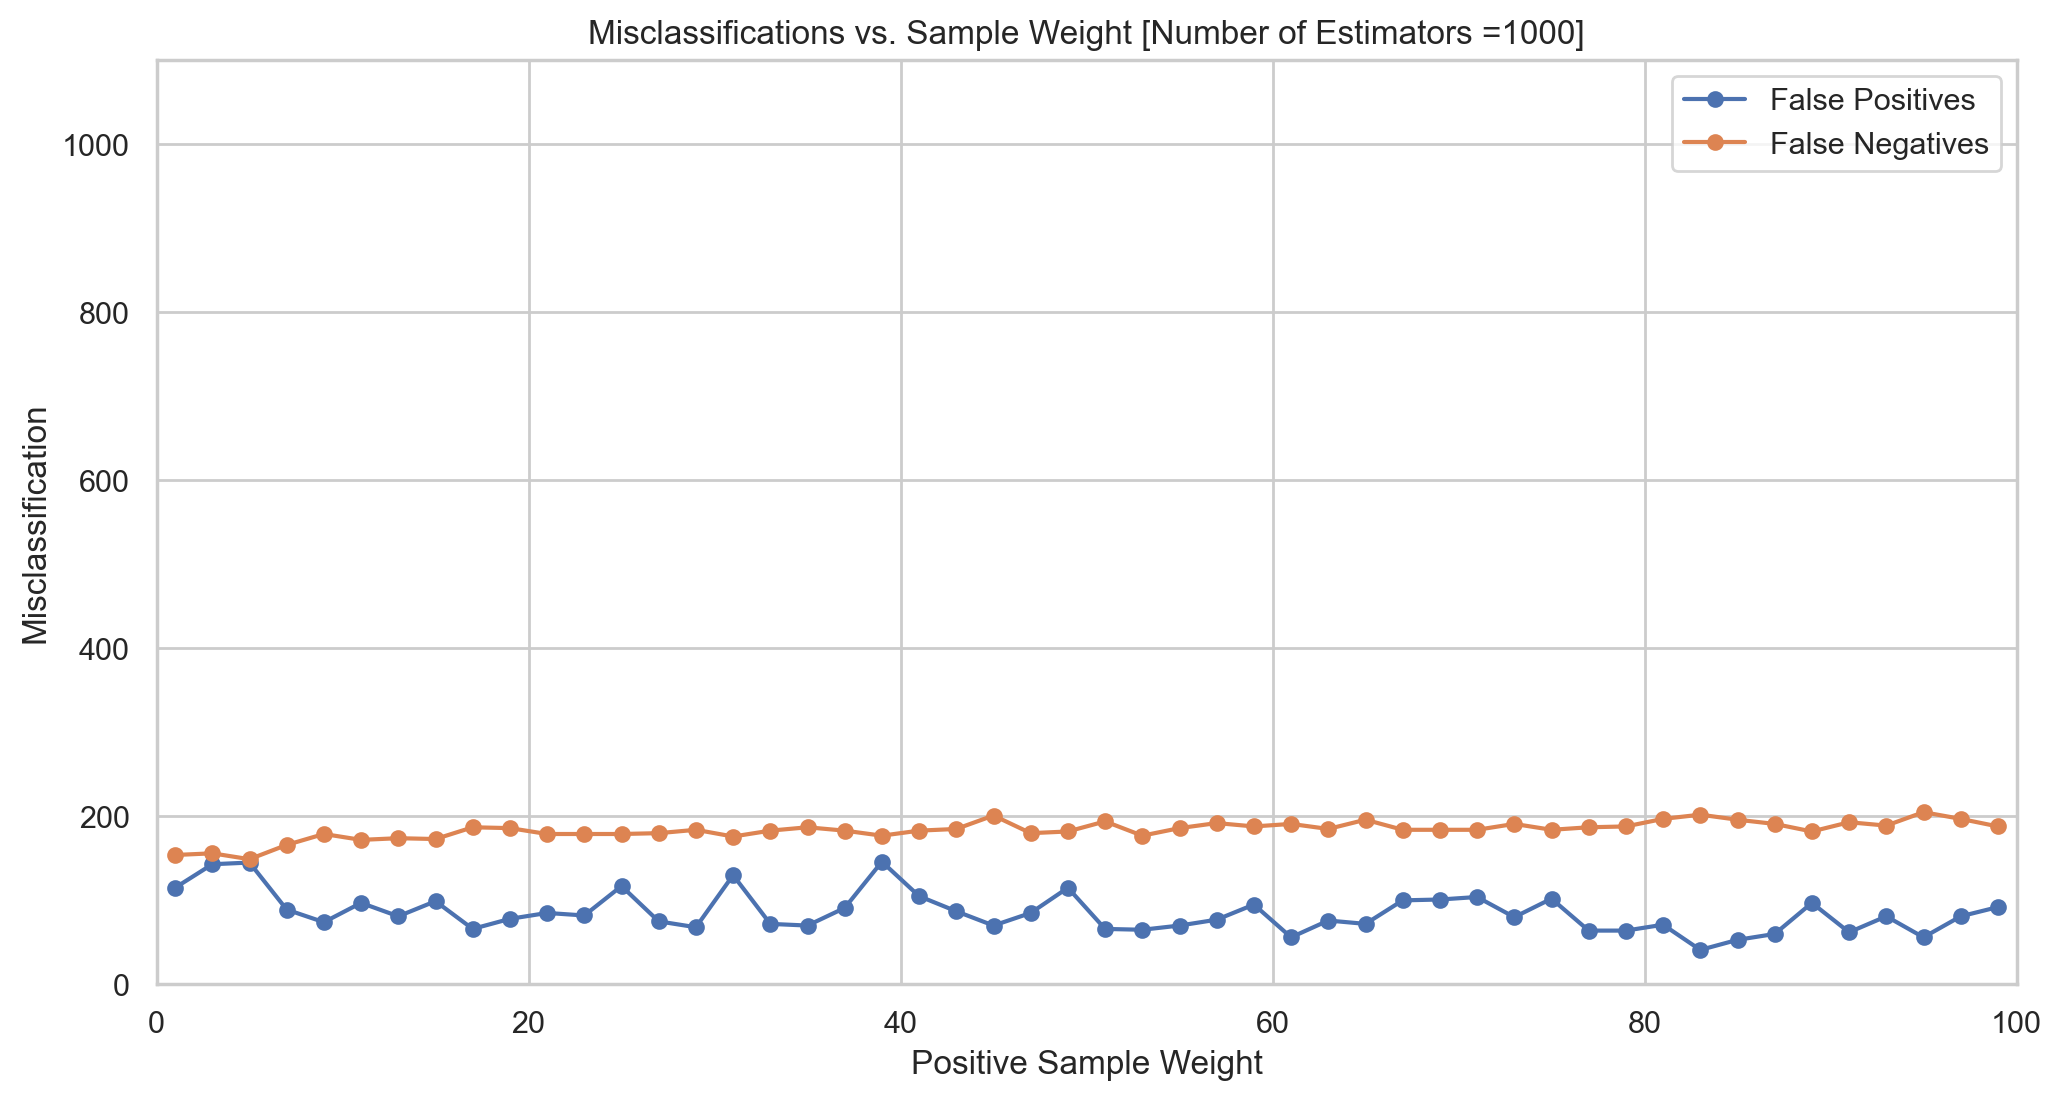

In [201]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(df_weights[2]['weight'], df_weights[2]['total_false_positives'], marker=".", markersize=10, label='False Positives')
ax.errorbar(df_weights[2]['weight'], df_weights[2]['total_false_negatives'], marker=".", markersize=10, label='False Negatives')
ax.set_ylabel('Misclassification')
ax.set_xlabel('Positive Sample Weight')
n_estimators = int(df_weights[2]['n_estimators'][0])
ax.set_title('Misclassifications vs. Sample Weight [Number of Estimators ='+str(n_estimators)+']')
ax.legend()
ax.set_ylim(0,1100)
ax.set_xlim(0,100)
fig.savefig('weightsversusmisclassifications_estimators_1000_gb.png', dpi=300, transparent=True, bbox_inches='tight')

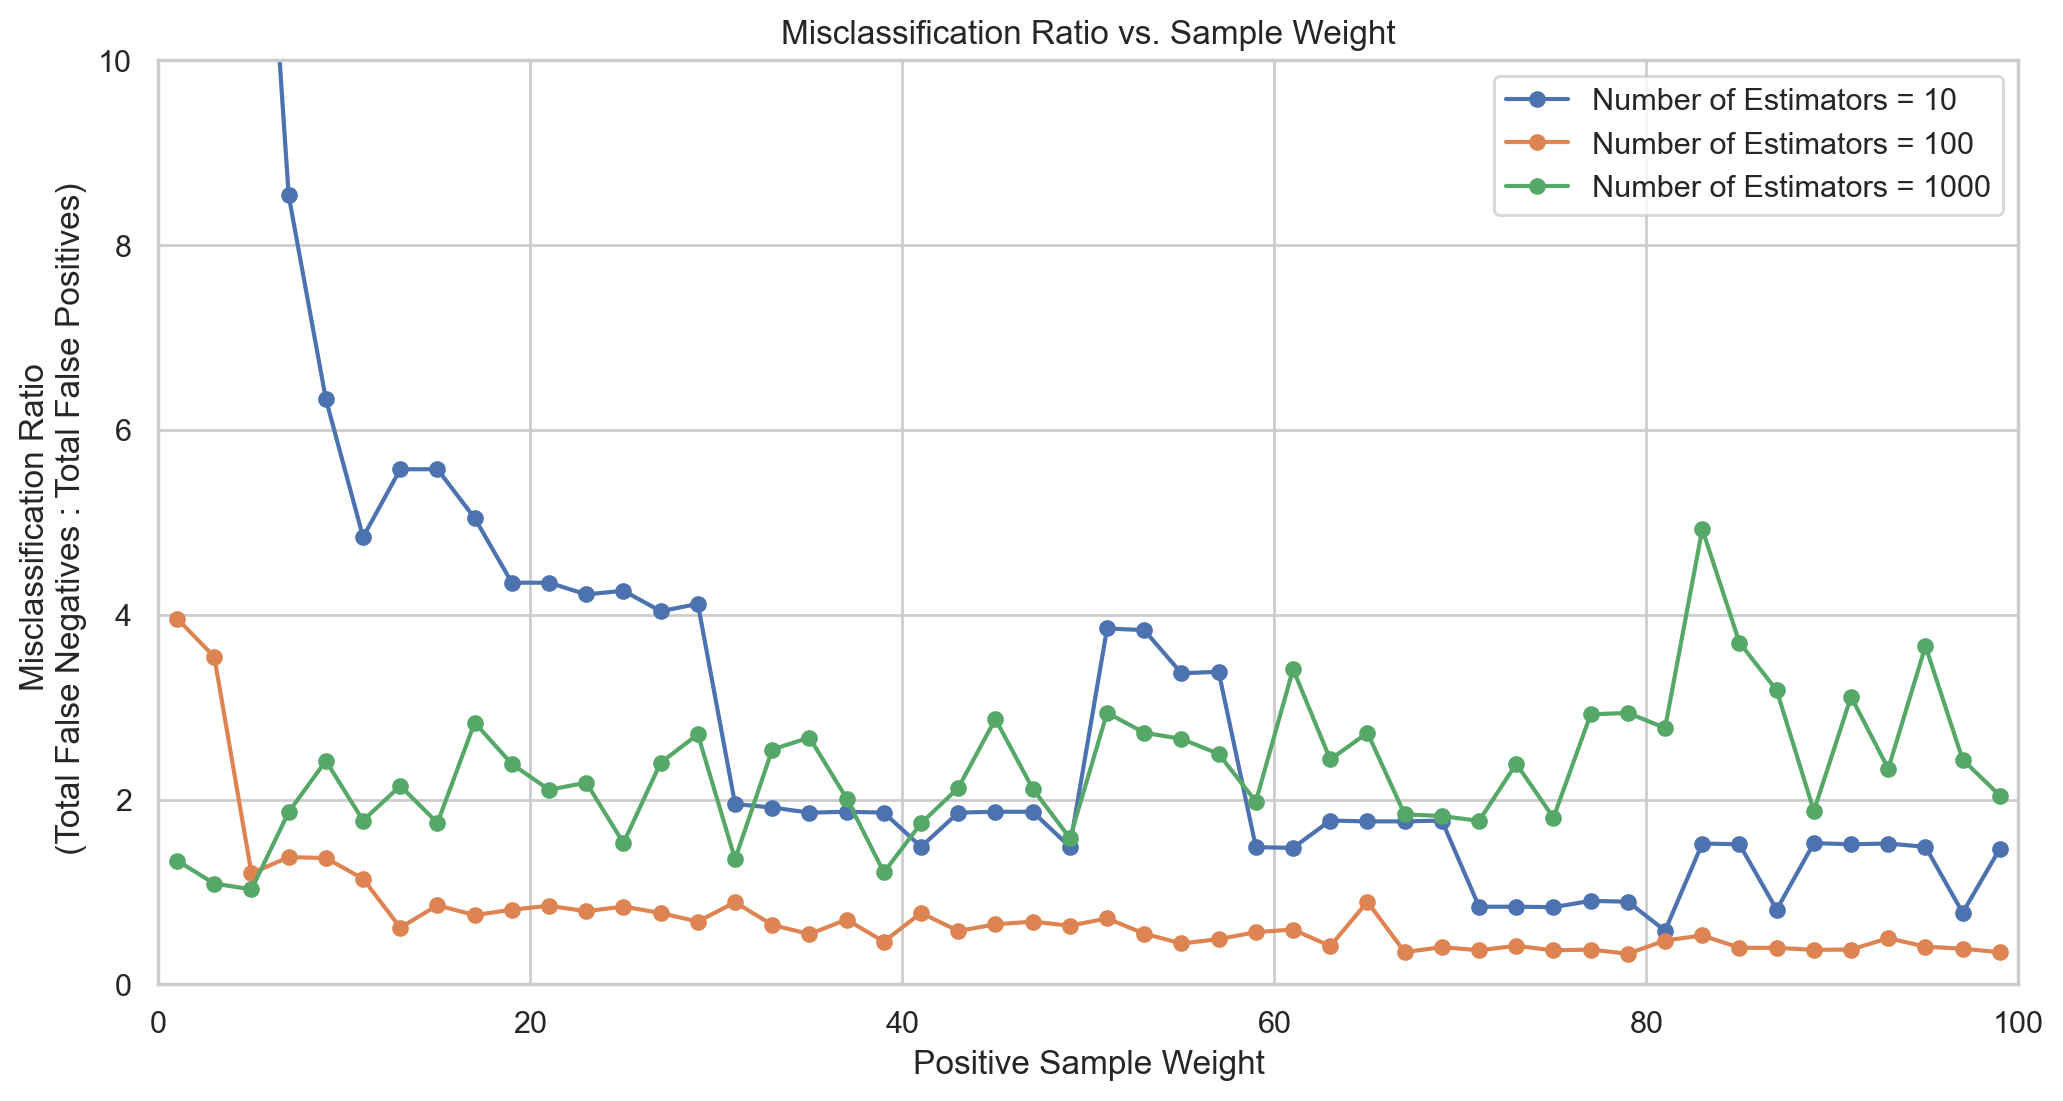

In [198]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(df_weights[0]['weight'], df_weights[0]['total_false_negatives']/df_weights[0]['total_false_positives'], marker=".", markersize=10, label='Number of Estimators = 10')
ax.errorbar(df_weights[1]['weight'], df_weights[1]['total_false_negatives']/df_weights[1]['total_false_positives'], marker=".", markersize=10, label='Number of Estimators = 100')
ax.errorbar(df_weights[2]['weight'], df_weights[2]['total_false_negatives']/df_weights[2]['total_false_positives'], marker=".", markersize=10, label='Number of Estimators = 1000')
ax.set_ylabel('Misclassification Ratio \n (Total False Negatives : Total False Positives)')
ax.set_xlabel('Positive Sample Weight')
ax.set_title('Misclassification Ratio vs. Sample Weight')
ax.set_ylim(0,10)
ax.set_xlim(0,100)
ax.legend()
#fig.savefig('weightsversusmisclassificationsratio_estimators_gb.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 4: Can we generate any counterfactual examples?

A counterfactual example explains what would have had to happen to get the desired result.
Looking at counterfactual examples with [DiCE](https://github.com/interpretml/DiCE).

In [263]:
# Step 1: Data for dice_ml.Data
all_features_and_label = all_features + ['DroughtExperienced']

# Define the dice training set
df_dice_train_tmp = df_combined[df_combined['Water Year'] == 2021]
df_dice_train = df_dice_train_tmp[all_features_and_label]

# Define the dice validation set
df_dice_val_tmp = df_combined[df_combined['Water Year'] == 2022]
df_dice_val = df_dice_val_tmp[all_features]

# Dice the training set
d = dice_ml.Data(dataframe=df_dice_train, continuous_features=numeric_features, outcome_name='DroughtExperienced')

In [264]:
# Step 2: Model for dice_ml
m = dice_ml.Model(model=model, backend="sklearn")

In [265]:
# Step 3: Dice
exp = dice_ml.Dice(d, m, method="random")

In [283]:
e1 = exp.generate_counterfactuals(df_dice_val[14:16], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=False)

  0%|                                                     | 0/2 [00:00<?, ?it/s]X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without

Query instance (original outcome : 0)


,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Total Number of Water Sources,Score_SCV,Score_SCM,Score_CriticallyOverdraftedGroundwaterBasin,Intertie,Wholesalers,Curtailment,HUC_Categories,DroughtExperienced
0,16.0,50,38.693722,-119.779686,0.0,0.0,0.0,2.0,0.0,0.0,1,0.0,0.0,0,3,0



Diverse Counterfactual set (new outcome: 1.0)


,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Total Number of Water Sources,Score_SCV,Score_SCM,Score_CriticallyOverdraftedGroundwaterBasin,Intertie,Wholesalers,Curtailment,HUC_Categories,DroughtExperienced
0,16.0,50.0,38.693723,-119.779683,0.0,46.9151,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1
1,16.0,50.0,38.693723,-119.779683,0.0,44.0042,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1


Query instance (original outcome : 0)


,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Total Number of Water Sources,Score_SCV,Score_SCM,Score_CriticallyOverdraftedGroundwaterBasin,Intertie,Wholesalers,Curtailment,HUC_Categories,DroughtExperienced
0,167.0,25,38.693722,-119.779686,0.0,0.0,0.0,3.0,0.0,0.0,0,0.0,0.0,0,3,0



Diverse Counterfactual set (new outcome: 1.0)


,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Total Number of Water Sources,Score_SCV,Score_SCM,Score_CriticallyOverdraftedGroundwaterBasin,Intertie,Wholesalers,Curtailment,HUC_Categories,DroughtExperienced
0,167.0,25.0,38.693723,-119.779683,457.5,180.1216,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1
1,167.0,25.0,38.693723,-119.779683,0.0,104.2828,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1


In [284]:
e1.visualize_as_list(show_only_changes=False)

Query instance (original outcome : 0)
[16.0, 50, 38.693721771240234, -119.7796859741211, 0.0, 0.0, 0.0, 2.0, '0.0', '0.0', '1', '0.0', '0.0', '0', '3', 0]

Diverse Counterfactual set (new outcome: 1.0)
[16.0, 50.0, 38.6937227, -119.7796826, 0.0, 46.9151, 0.0, 2.0, '1.0', 0.0, 1.0, 0.0, 0.0, 0.0, 3.0, 1]
[16.0, 50.0, 38.6937227, -119.7796826, 0.0, 44.0042, 0.0, 2.0, '1.0', 0.0, 1.0, 0.0, 0.0, 0.0, 3.0, 1]
Query instance (original outcome : 0)
[167.0, 25, 38.693721771240234, -119.7796859741211, 0.0, 0.0, 0.0, 3.0, '0.0', '0.0', '0', '0.0', '0.0', '0', '3', 0]

Diverse Counterfactual set (new outcome: 1.0)
[167.0, 25.0, 38.6937227, -119.7796826, 457.5, 180.1216, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1]
[167.0, 25.0, 38.6937227, -119.7796826, 0.0, 104.2828, 0.0, 3.0, '1.0', 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1]


In [272]:
query_instance = df_dice_val[0:1]
imp = exp.local_feature_importance(query_instance, total_CFs=10)
print(imp.local_importance)

  0%|                                                     | 0/1 [00:00<?, ?it/s]X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without feature names
X has feature names, but GradientBoostingClassifier was fitted without

[{'Score_SCM': 1.0, 'Wholesalers': 1.0, 'Curtailment': 1.0, 'HUC_Categories': 1.0, 'Score_SCV': 0.9, 'Score_CriticallyOverdraftedGroundwaterBasin': 0.9, 'Intertie': 0.9, 'Total Number of Water Sources': 0.8, 'DSCI Dry Season Average': 0.2, 'ServiceConnections': 0.1, 'Population': 0.1, 'PWPhysicalAddressLat': 0.1, 'PWPhysicalAddressLong': 0.0, 'DSCI Wet Season Average': 0.0, 'DSCI Dry Wet Delta': 0.0}]


### Question 5: Do different labels improve model performance?

In [202]:
print("Number of positive examples in DroughtExperienced:",len(df_combined[df_combined['DroughtExperienced'] == 1]))
print("Number of positive examples in WaterOutageDroughtViolation:",len(df_combined[df_combined['WaterOutageDroughtViolation'] == 1]))
print("Number of positive examples in BottledHauledWaterOrZeroSource:",len(df_combined[df_combined['BottledHauledWaterOrZeroSource'] == 1]))
print("Number of positive examples in Score_1702:",len(df_combined[df_combined['Score_1702'] == 1]))
print("Number of positive examples in Score_1704:",len(df_combined[df_combined['Score_1704'] == 1]))
print("Number of positive examples in FundedProject:",len(df_combined[df_combined['FundedProject'] == 1]))

Number of positive examples in DroughtExperienced: 459
Number of positive examples in WaterOutageDroughtViolation: 19
Number of positive examples in BottledHauledWaterOrZeroSource: 124
Number of positive examples in Score_1702: 111
Number of positive examples in Score_1704: 118
Number of positive examples in FundedProject: 153


In [203]:
outcome_label = [
 'DroughtExperienced',
 'WaterOutageDroughtViolation',
 'BottledHauledWaterOrZeroSource',
 'Score_1702',
 'Score_1704',
 'FundedProject',
 'CurtailmentExemptionPetition']

In [204]:
%%capture

auc_values_per_label = []
auc_std_per_label = []
kappa_values_per_label = []
kappa_std_per_label = []

for k in range(len(outcome_label)):
    # Select the outcome label
    y = df_combined[outcome_label[k]]
    print(outcome_label[k])

    auc_values = []
    auc_std = []
    kappa_values = []
    kappa_std = []
    for i in range(len(ordered_features_fisher)):
        # Select the features
        X = df_combined[ordered_features_fisher[i:]]
        total_features = X.columns.to_list()

        auc_scores = []
        kappa_scores = []
        for j in range(3):    # This should eventually be 100
            # Use 2021 as the training data and 2022 as the testing data
            training_index = df_combined[df_combined['Water Year'] == 2021].index
            validation_index = df_combined[df_combined['Water Year'] == 2022].index

            X_train = X.loc[training_index]
            X_val = X.loc[validation_index]
            y_train = y.loc[training_index]
            y_val = y.loc[validation_index]
            
            # Identify the numeric and categorical features
            total_numeric_features = list(set(total_features).intersection(numeric_features))
            total_categorical_features = list(set(total_features).intersection(categorical_features))

            # Select and scale the numeric features
            if total_numeric_features:
                scaler = preprocessing.StandardScaler()
                X_train_numeric = X_train[total_numeric_features]
                X_val_numeric = X_val[total_numeric_features]
                X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
                X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

            # Select the categorical features
            if total_categorical_features:
                X_train_categorical = np.array(X_train[total_categorical_features])
                X_val_categorical = np.array(X_val[total_categorical_features])

            # Create training and validation sets
            if total_numeric_features and total_categorical_features:
                X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
                X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)
            if total_numeric_features and not total_categorical_features:
                X_train_scaled = X_train_numeric_scaled
                X_val_scaled = X_val_numeric_scaled
            if not total_numeric_features and total_categorical_features:
                X_train_scaled = X_train_categorical
                X_val_scaled = X_val_categorical

            # Train the model
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_val_scaled)

            # Calculate the AUC
            rfc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_val_scaled, y_val, response_method='predict_proba');
            auc_scores.append(rfc_disp.roc_auc);
            
            # Calculate Cohen's Kappa Score
            kappa_score = metrics.cohen_kappa_score(y_val, y_pred)
            kappa_scores.append(kappa_score)
        
        auc_std.append(np.std(auc_scores))
        auc_values.append(np.mean(auc_scores))
        kappa_std.append(np.std(kappa_scores))
        kappa_values.append(np.mean(kappa_scores))
        print(i,np.mean(auc_scores), np.std(auc_scores))
        print(i,np.mean(kappa_scores), np.std(kappa_scores))

    auc_std_per_label.append(auc_std)
    auc_values_per_label.append(auc_values)
    kappa_std_per_label.append(kappa_std)
    kappa_values_per_label.append(kappa_values)

In [205]:
df_auc = pd.DataFrame({'AUC Scores': auc_values_per_label, 
                       'AUC Standard Deviation': auc_std_per_label,
                       'Kappa Scores': kappa_values_per_label, 
                       'Kappa Standard Deviation': kappa_std_per_label, 
                       'Outcome Label': outcome_label})

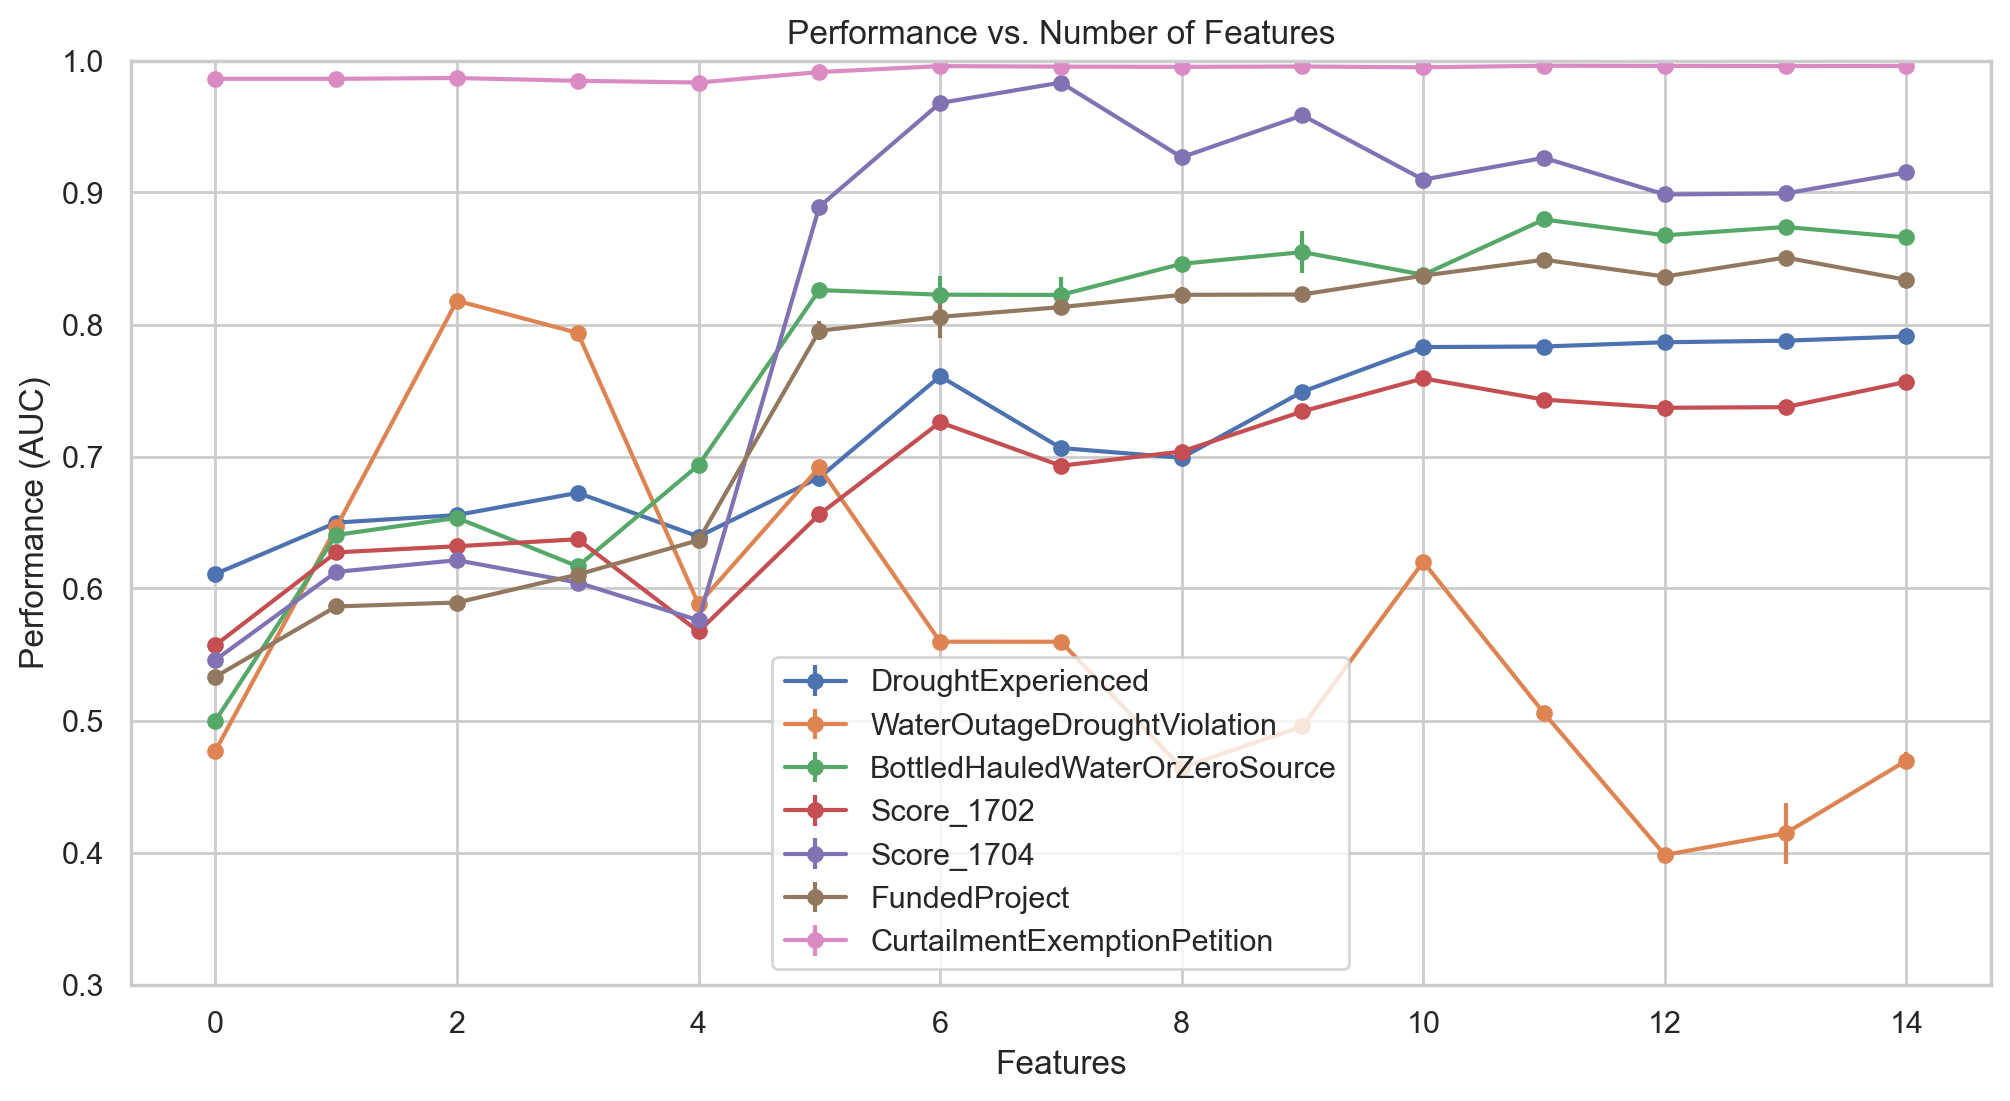

In [208]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(np.arange(len(df_auc['AUC Scores'][0])),np.flip(df_auc['AUC Scores'][0]), yerr=np.flip(df_auc['AUC Standard Deviation'][0]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][0])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][1])),np.flip(df_auc['AUC Scores'][1]), yerr=np.flip(df_auc['AUC Standard Deviation'][1]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][1])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][2])),np.flip(df_auc['AUC Scores'][2]), yerr=np.flip(df_auc['AUC Standard Deviation'][2]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][2])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][3])),np.flip(df_auc['AUC Scores'][3]), yerr=np.flip(df_auc['AUC Standard Deviation'][3]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][3])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][4])),np.flip(df_auc['AUC Scores'][4]), yerr=np.flip(df_auc['AUC Standard Deviation'][4]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][4])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][5])),np.flip(df_auc['AUC Scores'][5]), yerr=np.flip(df_auc['AUC Standard Deviation'][5]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][5])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][6])),np.flip(df_auc['AUC Scores'][6]), yerr=np.flip(df_auc['AUC Standard Deviation'][6]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][6])
ax.set_xlabel('Features')
ax.set_ylabel('Performance (AUC)')
ax.set_title('Performance vs. Number of Features')
ax.set_ylim([0.3, 1.00])
ax.legend()
fig.savefig('performancevsfeaturesvslabel_auc_gb.png', dpi=300, transparent=True, bbox_inches='tight')

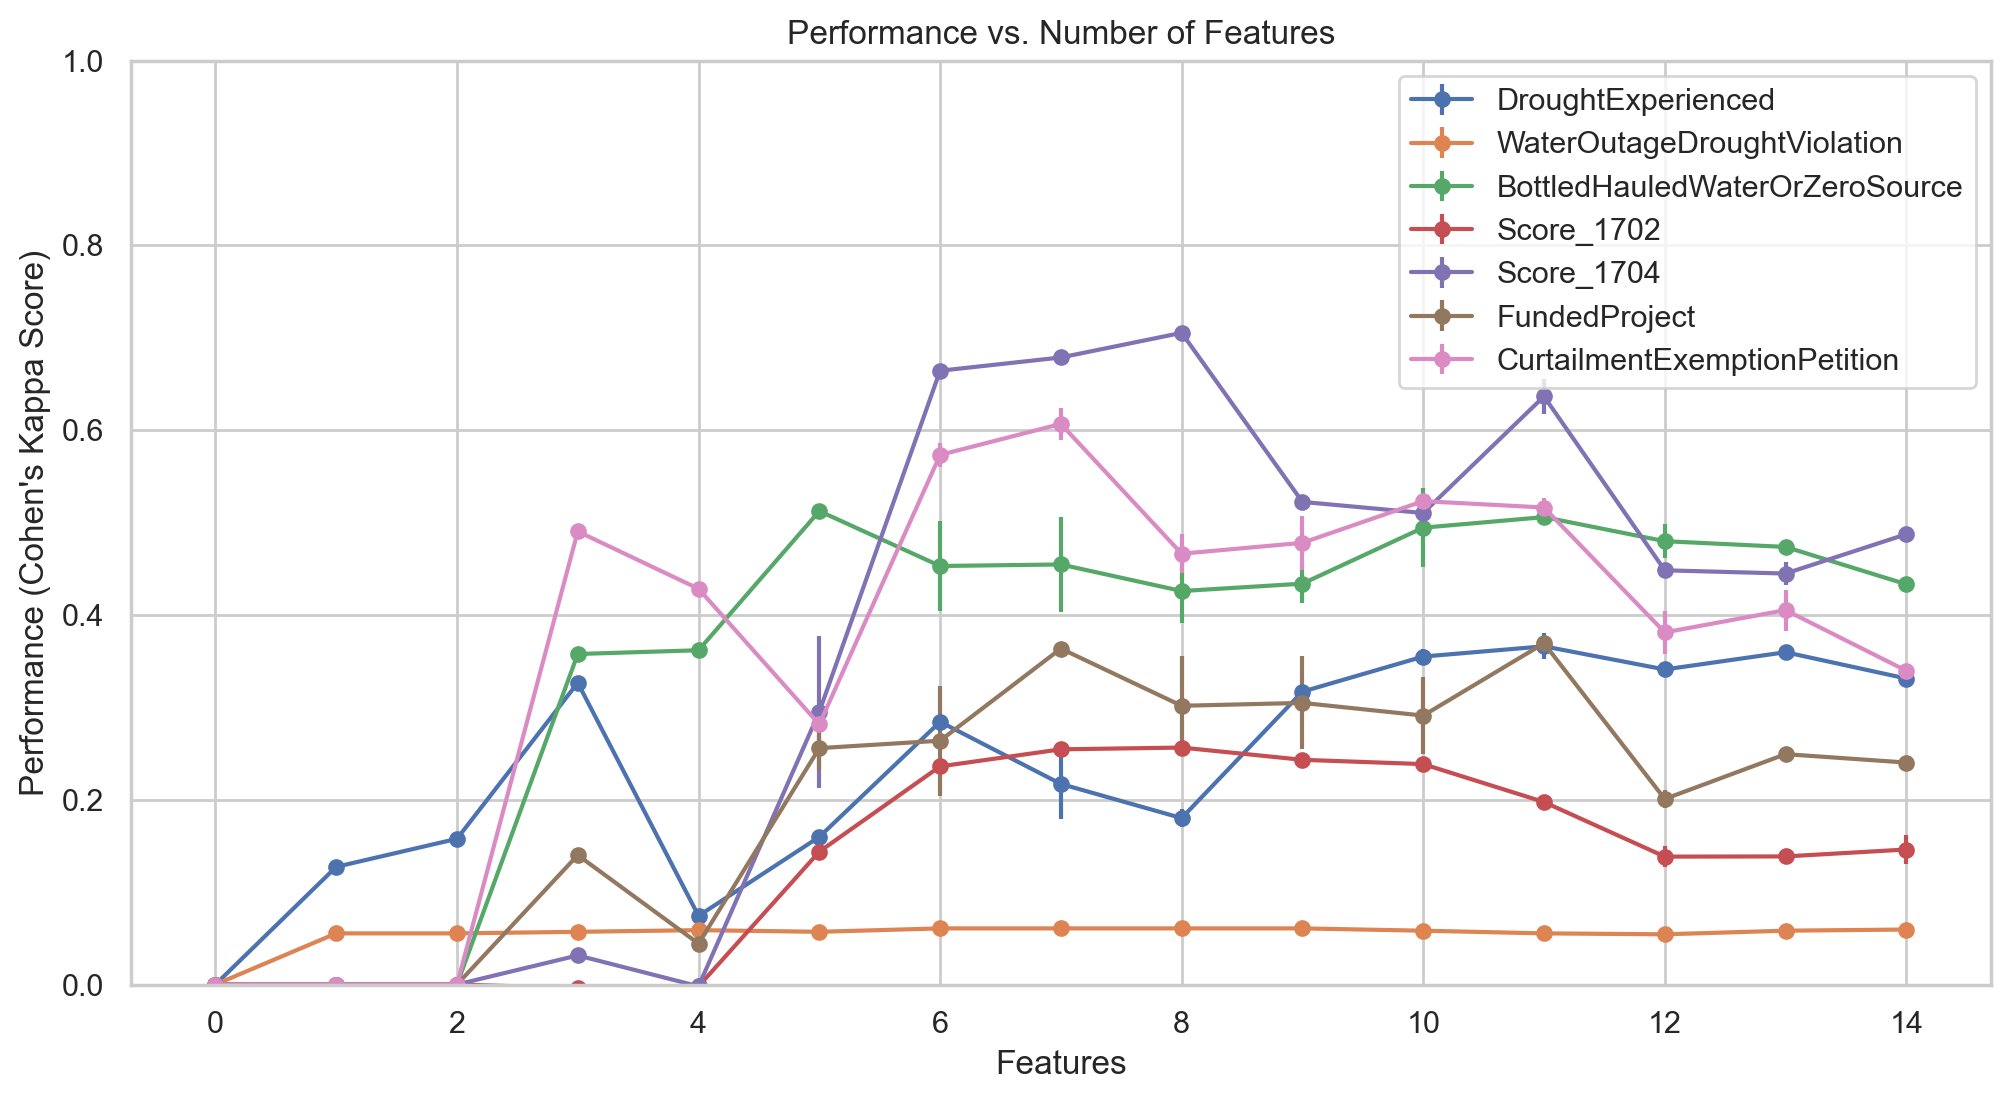

In [209]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(np.arange(len(df_auc['Kappa Scores'][0])),np.flip(df_auc['Kappa Scores'][0]), yerr=np.flip(df_auc['Kappa Standard Deviation'][0]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][0])
ax.errorbar(np.arange(len(df_auc['Kappa Scores'][1])),np.flip(df_auc['Kappa Scores'][1]), yerr=np.flip(df_auc['Kappa Standard Deviation'][1]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][1])
ax.errorbar(np.arange(len(df_auc['Kappa Scores'][2])),np.flip(df_auc['Kappa Scores'][2]), yerr=np.flip(df_auc['Kappa Standard Deviation'][2]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][2])
ax.errorbar(np.arange(len(df_auc['Kappa Scores'][3])),np.flip(df_auc['Kappa Scores'][3]), yerr=np.flip(df_auc['Kappa Standard Deviation'][3]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][3])
ax.errorbar(np.arange(len(df_auc['Kappa Scores'][4])),np.flip(df_auc['Kappa Scores'][4]), yerr=np.flip(df_auc['Kappa Standard Deviation'][4]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][4])
ax.errorbar(np.arange(len(df_auc['Kappa Scores'][5])),np.flip(df_auc['Kappa Scores'][5]), yerr=np.flip(df_auc['Kappa Standard Deviation'][5]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][5])
ax.errorbar(np.arange(len(df_auc['Kappa Scores'][6])),np.flip(df_auc['Kappa Scores'][6]), yerr=np.flip(df_auc['Kappa Standard Deviation'][6]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][6])
ax.set_xlabel('Features')
ax.set_ylabel('Performance (Cohen\'s Kappa Score)')
ax.set_title('Performance vs. Number of Features')
ax.set_ylim([0.0, 1.00])
ax.legend()
fig.savefig('performancevsfeaturesvslabel_Kappa_gb.png', dpi=300, transparent=True, bbox_inches='tight')